# Predictive Maintenance - Classification Problem

## Importing Data from UCI

Predictive Maintenance Dataset from UCI

https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601)

# data (as pandas dataframes)
X = ai4i_2020_predictive_maintenance_dataset.data.features
y = ai4i_2020_predictive_maintenance_dataset.data.targets

# metadata
print(ai4i_2020_predictive_maintenance_dataset.metadata)

# variable information
print(ai4i_2020_predictive_maintenance_dataset.variables)

{'uci_id': 601, 'name': 'AI4I 2020 Predictive Maintenance Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/601/data.csv', 'abstract': 'The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression', 'Causal-Discovery'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 10000, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'index_col': ['UID', 'Product ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5HS5C', 'creators': [], 'intro_paper': {'title': 'Explainable Artificial Intelligence for Predictive Maintenance

**Confirming there is no missing values and checking the dtypes of the features and target**

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 468.9+ KB


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Machine failure  10000 non-null  int64
 1   TWF              10000 non-null  int64
 2   HDF              10000 non-null  int64
 3   PWF              10000 non-null  int64
 4   OSF              10000 non-null  int64
 5   RNF              10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB


## Data Cleaning

There are no missing values in the data since its a secondary data. However, the data might have outliers.

### **Dealing with categorical data**

Product Type varibale / feature signifies the product quality from Low, Medium and High from the production machines. Categories has inherent order such as Low, Medium and High, so they can be label encoded. But one hot encoding provides much domain explanation.

#### One Hot endcoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

type_encoded = encoder.fit_transform(X[['Type']]).toarray()

type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['Type']))

# Concatenate the original DataFrame with the encoded DataFrame
X = pd.concat([X.drop('Type', axis=1), type_encoded_df], axis=1)

X.head(5)

Air temperature  Process temperature  Rotational speed  Torque  Tool wear  \
0            298.1                308.6              1551    42.8          0   
1            298.2                308.7              1408    46.3          3   
2            298.1                308.5              1498    49.4          5   
3            298.2                308.6              1433    39.5          7   
4            298.2                308.7              1408    40.0          9   

   Type_H  Type_L  Type_M  
0     0.0     0.0     1.0  
1     0.0     1.0     0.0  
2     0.0     1.0     0.0  
3     0.0     1.0     0.0  
4     0.0     1.0     0.0

### Meaningless Data

Machine Failure without any other failure modes is not possible. Indentifying the data that doesnt make any sense...

In [ ]:
# useless data?
condition = (y['Machine failure'] == 1) & (y[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) == 0)
result = y[condition]
del_idx = result.index
result

Machine failure  TWF  HDF  PWF  OSF  RNF
1437                1    0    0    0    0    0
2749                1    0    0    0    0    0
4044                1    0    0    0    0    0
4684                1    0    0    0    0    0
5536                1    0    0    0    0    0
5941                1    0    0    0    0    0
6478                1    0    0    0    0    0
8506                1    0    0    0    0    0
9015                1    0    0    0    0    0

These data points depicts the machine failure without any other failure modes, representing true anamoly (Unknown reasons). For a classification task, these anamolies also can act as outliers, unless carefully treated along with domain knowledge.

In [ ]:
# drop those indexes
y = y.drop(del_idx)
X = X.drop(del_idx)

y = y.reset_index(drop=True)
X = X.reset_index(drop=True)

print(X.shape, y.shape)

(9991, 8) (9991, 6)


### Binary & Multi-label Target

In [ ]:
# multi label
y.head(5)
y_main = y
y_main

Machine failure  TWF  HDF  PWF  OSF  RNF
0                   0    0    0    0    0    0
1                   0    0    0    0    0    0
2                   0    0    0    0    0    0
3                   0    0    0    0    0    0
4                   0    0    0    0    0    0
...               ...  ...  ...  ...  ...  ...
9986                0    0    0    0    0    0
9987                0    0    0    0    0    0
9988                0    0    0    0    0    0
9989                0    0    0    0    0    0
9990                0    0    0    0    0    0

[9991 rows x 6 columns]

In [ ]:
# Since the failure is determined by the any one occurance of the failure modes;
# restoring the binary class as the target variable -> y['Machine failure']
y=y['Machine failure']
y

0       0
1       0
2       0
3       0
4       0
       ..
9986    0
9987    0
9988    0
9989    0
9990    0
Name: Machine failure, Length: 9991, dtype: int64

### Outlier Analysis

1. https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
2. https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/


#### Viz

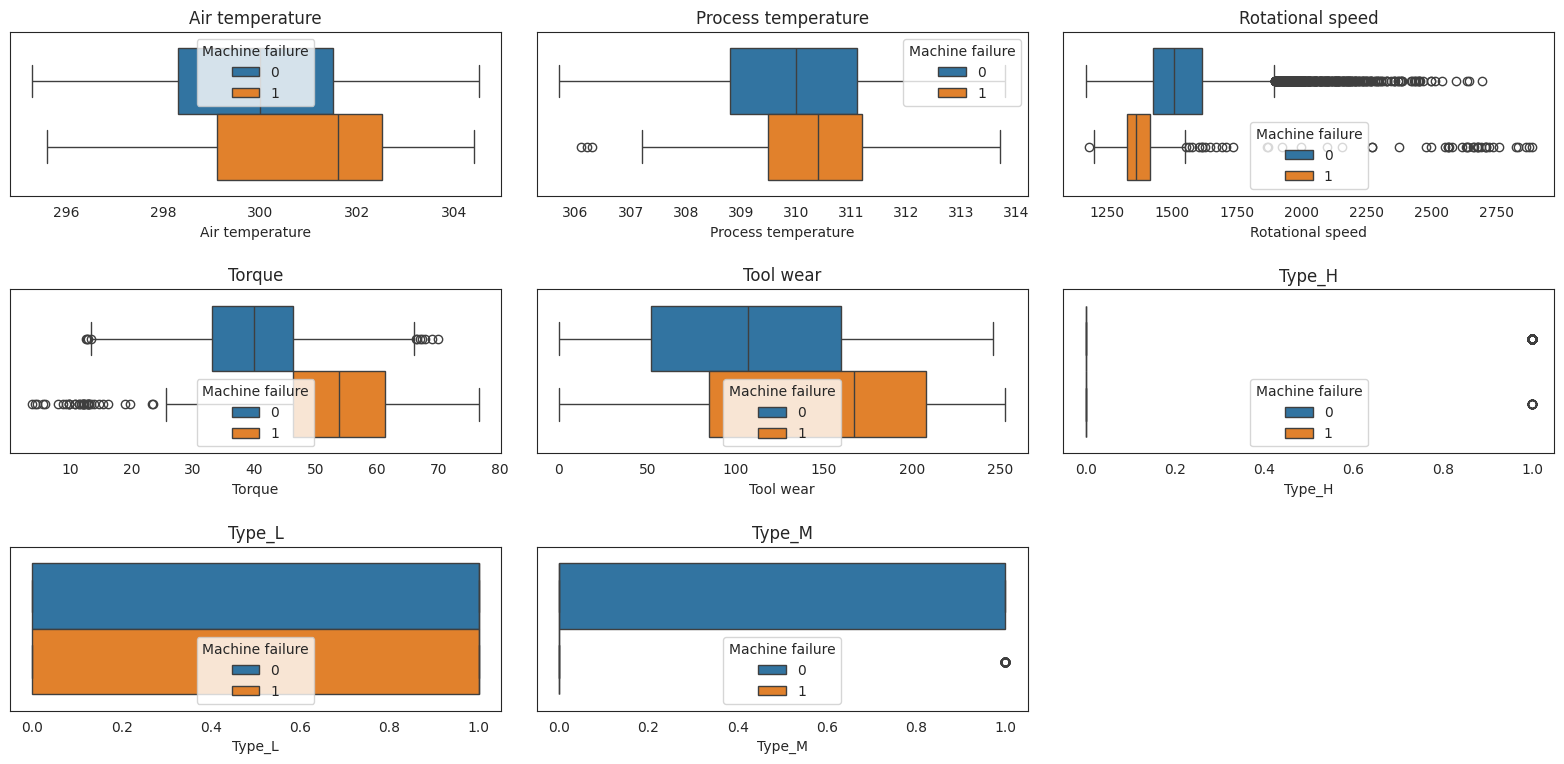

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_style("white")
features = X.columns
num_features = len(features)

# Determine the number of rows and columns needed
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Flatten the axes array if it's 2D for easy iteration
axes = axes.flatten()

# Subplots
for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], x=X[feature], hue=y)
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import math

# Assuming X is a DataFrame and y is a Series

features = X.columns
num_features = len(features)

# Determine the number of rows and columns needed
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=features)

# Define colors
colors = {'0': 'blue', '1': 'red'}

# Add boxplots for each feature
for i, feature in enumerate(features):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    for label in y.unique():
        fig.add_trace(
            go.Box(
                x=X[y == label][feature],
                name=str(label),  # Show label name only for the first plot
                boxmean=True,
                orientation='h',
                marker_color=colors[str(label)],
                #showlegend=(i == 0)  # Show legend only for the first plot
            ),
            row=row, col=col
        )

# Update layout
fig.update_layout(
    height=800, width=1200,
    title_text="Box Plot - Outlier Visualization",
    title_x=0.5,  # Center the title horizontally
    title_xanchor='center',  # Anchor the title to the center
    showlegend=False,
    template='plotly_white'
)

# Hide grid and labels
for i, feature in enumerate(features):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1
    fig.update_xaxes(showgrid=False, row=row, col=col)
    fig.update_yaxes(showgrid=False, row=row, col=col)

fig.show()


By looking at the box plot, it is clear that Rotational Speed and Torque has some outliers beyond the whiskers. I need to confirm that the outliers are not from the minority class.

It is clear that the minority class "1" has most of the outliers. But according to domain knowledge aquired from Industries, mostly outliers are the one which causes the machines to failure.

Is it better to have them during model training?

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

#### Process Temperature

In [ ]:
# outlier analysis
# identify outliers with interquartile range
from numpy import percentile

print('Process Temperature:')
# IQR = Q75 - Q25
q25, q75 = percentile(X['Process temperature'], 25), percentile(X['Process temperature'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(f"Lower limit: {lower}, Upper limit: {upper}")
# outliers
outliers = [x for x in X['Process temperature'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Process Temperature:
Percentiles: 25th=308.800, 75th=311.100, IQR=2.300
Lower limit: 305.35, Upper limit: 314.55000000000007
Identified outliers: 0


#### Rotational speed

In [ ]:
print('Rotational speed:')

# IQR = Q75 - Q25
q25, q75 = percentile(X['Rotational speed'], 25), percentile(X['Rotational speed'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(f"Lower limit: {lower}, Upper limit: {upper}")
# outliers
outliers = [x for x in X['Rotational speed'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Rotational speed:
Percentiles: 25th=1423.000, 75th=1612.000, IQR=189.000
Lower limit: 1139.5, Upper limit: 1895.5
Identified outliers: 418


#### Torque

In [ ]:
print('Torque:')
# IQR = Q75 - Q25
q25, q75 = percentile(X['Torque'], 25), percentile(X['Torque'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(f"Lower limit: {lower}, Upper limit: {upper}")
# outliers
outliers = [x for x in X['Torque'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Torque:
Percentiles: 25th=33.200, 75th=46.700, IQR=13.500
Lower limit: 12.950000000000003, Upper limit: 66.95
Identified outliers: 70


In this case, outlier removal by IQR may seem to remove some main minority class data. There is a need to implement automatic outlier detection. Automatic outlier detection algorithms may perform differently based on the distribution and clustering of outliers

### Automatic Outlier Detection

1. Local Outlier Factor (LOF)

2. Isolation Forest

3. One-Class SVM

4. Elliptic Envelope

In [ ]:
def remove_outliers(X, y, outlier_detector):
    if hasattr(outlier_detector, 'fit_predict'):
        y_pred = outlier_detector.fit_predict(X)
    else:
        y_pred = outlier_detector.fit(X).predict(X)
    mask = y_pred != -1  # To Keep inliers
    return X[mask], y[mask]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

outlier_methods = {
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20),
    'IsolationForest': IsolationForest(contamination=0.1, random_state=42),
    'OneClassSVM': OneClassSVM(gamma='auto', nu=0.1),
    'EllipticEnvelope': EllipticEnvelope(contamination=0.1, random_state=42)
}

results = []

for method_name, method in outlier_methods.items():
    # Remove outliers
    X_clean, y_clean = remove_outliers(X, y, method)

    # Split the cleaned data
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

    # Train Random Forest
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Method': method_name,
        'Accuracy': accuracy,
        'F1 Score': f1
    })

results_df = pd.DataFrame(results)
print(results_df)

               Method  Accuracy  F1 Score
0  LocalOutlierFactor  0.988109  0.985262
1     IsolationForest  0.987232  0.984635
2         OneClassSVM  0.982826  0.976997
3    EllipticEnvelope  0.990939  0.989215


In [ ]:
results_df.set_index('Method', inplace=True)

In [ ]:
results_df

Accuracy  F1 Score
Method                                
LocalOutlierFactor  0.988109  0.985262
IsolationForest     0.987232  0.984635
OneClassSVM         0.982826  0.976997
EllipticEnvelope    0.990939  0.989215

<Figure size 640x480 with 0 Axes>

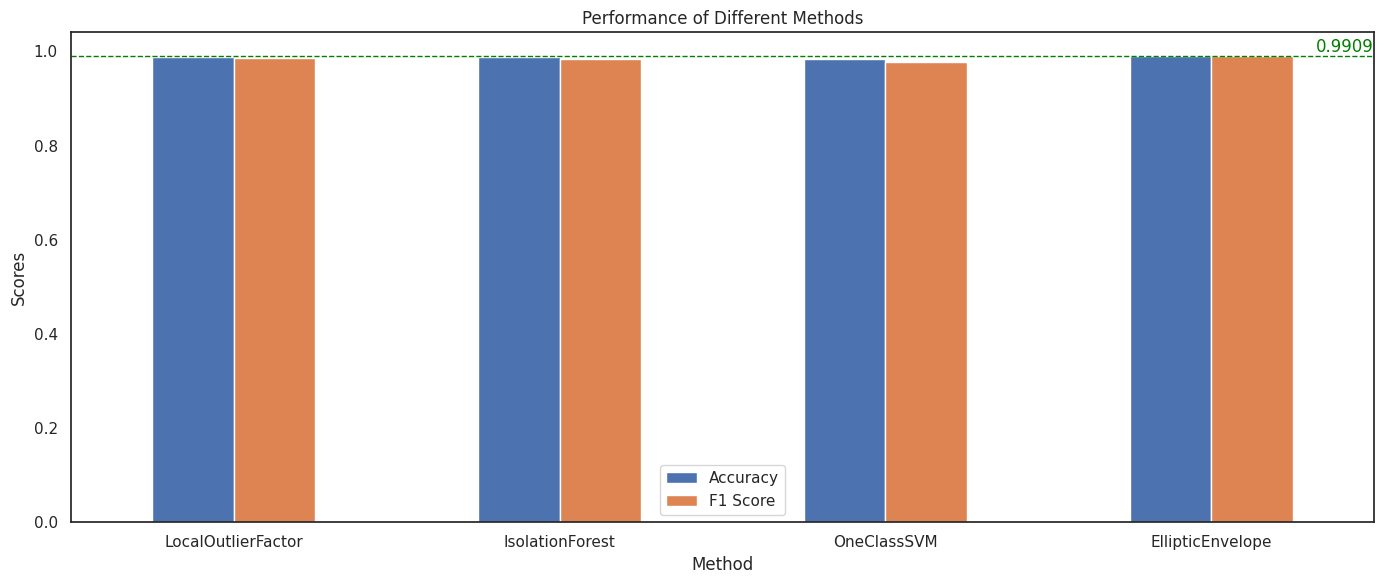

In [ ]:
plt.figure()
sns.set_style("white")
palette = sns.color_palette("deep")
sns.set_palette(palette)
# Find the maximum values
max_values = results_df.max()

ax = results_df.plot(kind='bar', figsize=(14, 6))

ax.axhline(y=max_values[0], color='green', linestyle='--', linewidth=1)
ax.text(x=len(results_df) - 0.5, y=max_values[0], s=f'{max_values[0]:.4f}',
        color='green', va='bottom', ha='right')

ax.set_title('Performance of Different Methods')
ax.set_xlabel('Method')
ax.set_ylabel('Scores')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

Elliptic Envelope is the best, not only achieve high accuracy but also high F1 scores, indicating robust performance in both precision and recall aspects of the classification task after removing outliers.

### Elliptic Envelope - Outlier Removal

In [ ]:
from sklearn.covariance import EllipticEnvelope
outD = EllipticEnvelope(contamination=0.1, random_state=42)

X, y = remove_outliers(X, y, outD)

# reset index
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(X.shape, y.shape)

(8992, 8) (8992,)


## PCA for 2D Viz

https://builtin.com/machine-learning/pca-in-python

In [ ]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features (m=0, v=1)
x_pca = StandardScaler().fit_transform(X)

# 2D data for Viz using PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y], axis = 1)
finalDf

PC1       PC2  Machine failure
0    -1.491842  1.607718                0
1    -1.098122 -1.512644                0
2    -0.987505 -1.433701                0
3    -0.616973 -1.234331                0
4    -0.721266 -1.301108                0
...        ...       ...              ...
8987 -0.391640  2.190832                0
8988 -0.281167  1.313725                0
8989 -0.357072  2.169935                0
8990 -2.090450  0.273968                0
8991 -1.327786  1.623252                0

[8992 rows x 3 columns]

In [ ]:
print(pca.explained_variance_ratio_)
print('Total Explained Variance of PC:', f"{round(pca.explained_variance_ratio_.sum()*100, 2)}%")

[0.24112231 0.23397117]
Total Explained Variance of PC: 47.51%


PC1 contributes to 28.70% variance and PC2 contributes to 27.23% variance. Its better to take Pricipal components which covers 55.94% of the total variance.

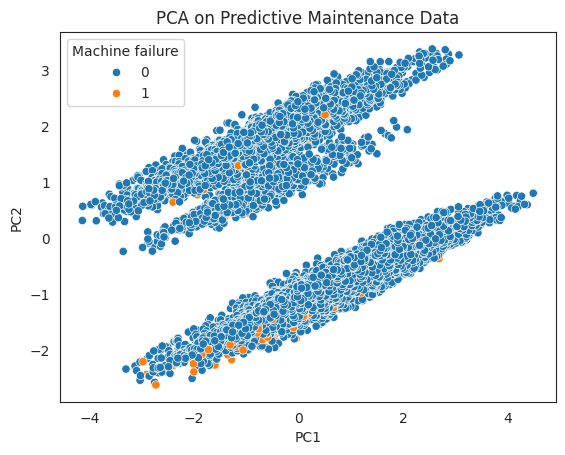

In [ ]:
# 2D viz (Low Dim) of the features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Machine failure')
plt.title("PCA on Predictive Maintenance Data")
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure()

# Add scatter plot traces
for label in finalDf['Machine failure'].unique():
    df_label = finalDf[finalDf['Machine failure'] == label]
    fig.add_trace(
        go.Scatter(
            x=df_label['PC1'],
            y=df_label['PC2'],
            mode='markers',
            name=str(label),
            marker=dict(color='blue' if label == 0 else 'red')
        )
    )

# Update layout
fig.update_layout(
    title="2D Scatter Plot of the reduced features",
    xaxis_title='PC1',
    yaxis_title='PC2',
    legend_title='Machine Failure',
    template='plotly_white'
)

# Show plot
fig.show()


<Axes: >

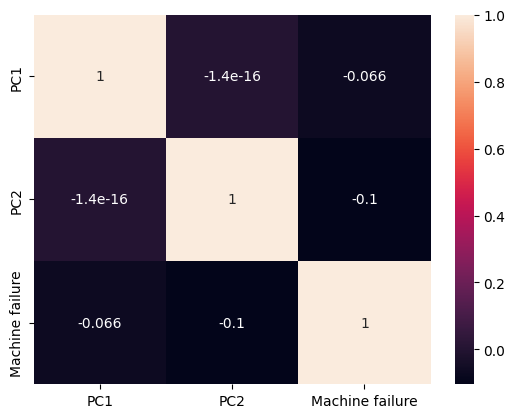

In [ ]:
import seaborn as sns
cor = finalDf.corr()

sns.heatmap(cor, annot=True)

## Dealing with Class Imbalance

In [ ]:
import pandas as pd
import plotly.express as px

# Assume y is your target variable (e.g., a pandas Series)
# Calculate class imbalance
class_0_var = y[y == 0].count() * 100 / y.count()
class_1_var = y[y == 1].count() * 100 / y.count()
print(f"Class 0: {class_0_var:.2f}%")
print(f"Class 1: {class_1_var:.2f}%")

# Create a DataFrame for easier plotting
data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})

# Create bar plot using Plotly
fig = px.bar(data, x='Class', y='Percentage', text='Percentage',
             title='Class Imbalance',
             labels={'Class': 'Class Label', 'Percentage': 'Percentage (%)'},
             color='Class',
             color_discrete_map={'0': 'blue', '1': 'red'})

# Update layout for better visualization
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    xaxis_title='Class Label',
    yaxis_title='Percentage (%)',
    showlegend=False,
    template='plotly_white',
    xaxis=dict(showgrid=False),  # Hide x-axis grid lines
    yaxis=dict(showgrid=False)   # Hide y-axis grid lines
)

# Show plot
fig.show()


Class 0: 97.82%
Class 1: 2.18%


Class (0): 97.78692170818505%
Class (1): 2.2130782918149468%


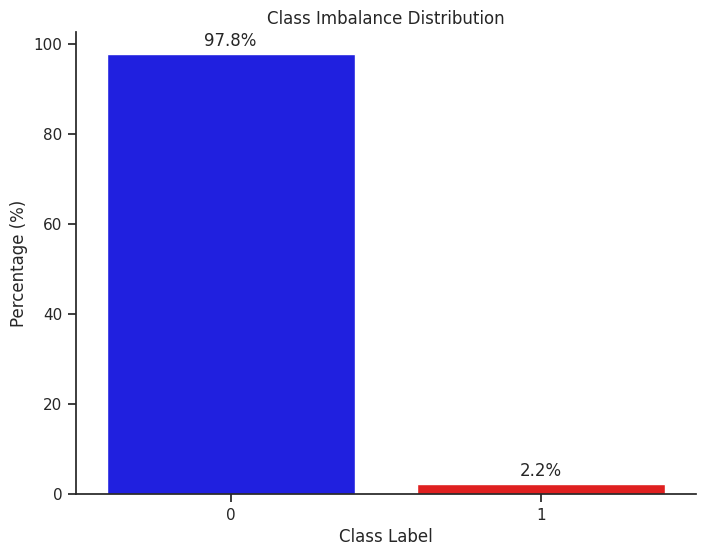

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# checking class imbalance
class_0_var = y[y==0].count() * 100 / y.count()
class_1_var = y[y==1].count() * 100 / y.count()
print(f"Class (0): {class_0_var}%")
print(f"Class (1): {class_1_var}%")

# Create a DataFrame for easier plotting
data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

g = sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

# Access bars and add percentage labels
bars = g.patches  # Get bar handles
for bar, perc in zip(bars, data['Percentage']):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom')


plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.title('Class Imbalance Distribution')
plt.show()

Model is only able to learn simple heuristic and gets stuck in the suboptimal solution when there is a class imbalance. High accuracy of the model in this case doesnt gaurentee the prediciton and the model can be misleading, i.e., baised towards the major class. The model may not have the predictive power on the rare class.

Often in real-world scenarios, the minor class is more important than the major class. A wrong prediciton on the minority class is way more costly than on the majority class. Therefore, class imbalance should be dealt with

https://www.kaggle.com/code/beinginvincible/dealing-with-class-imbalance-with-smote

### SMOTE

In [ ]:
# Applying Smote
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X, y)

print(X_smote.shape, y_smote.shape)

(17586, 8) (17586,)


Class (0): 50.0%
Class (1): 50.0%


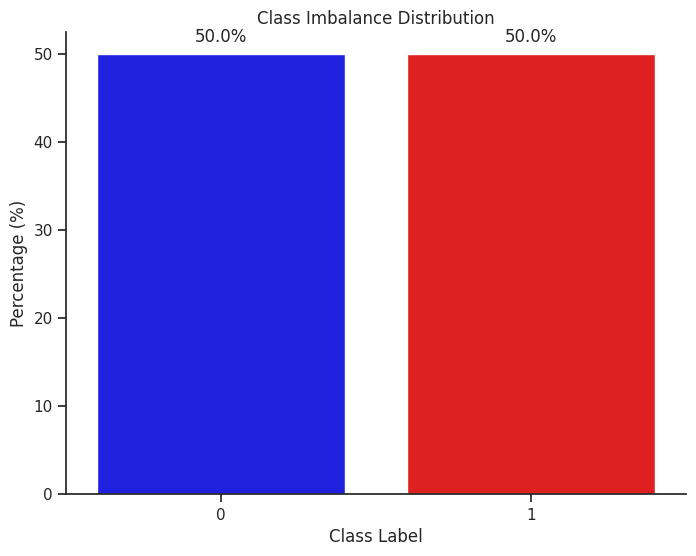

In [ ]:
# checking class imbalance
class_0_var = y_smote[y_smote==0].count() * 100 / y_smote.count()
class_1_var = y_smote[y_smote==1].count() * 100 / y_smote.count()
print(f"Class (0): {class_0_var}%")
print(f"Class (1): {class_1_var}%")

# Create a DataFrame for easier plotting
data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

g = sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

# Access bars and add percentage labels
bars = g.patches  # Get bar handles
for bar, perc in zip(bars, data['Percentage']):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom')


plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.title('Class Imbalance Distribution')
plt.show()

In [ ]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features (m=0, v=1)
x_pca = StandardScaler().fit_transform(X_smote)

# 2D data for Viz using PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y_smote], axis = 1)

# 2D viz (Low Dim) of the features
plt.figure()
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Machine failure')
plt.title("ADASYN on PDM Data")
plt.show()

### ADASYN

In [ ]:
# ADASYN
from imblearn.over_sampling import ADASYN

# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
X_ada, y_ada = ada. fit_resample(X, y)

print(X_ada.shape, y_ada.shape)

(17621, 8) (17621,)


Class (0): 49.91203677430339%
Class (1): 50.08796322569661%


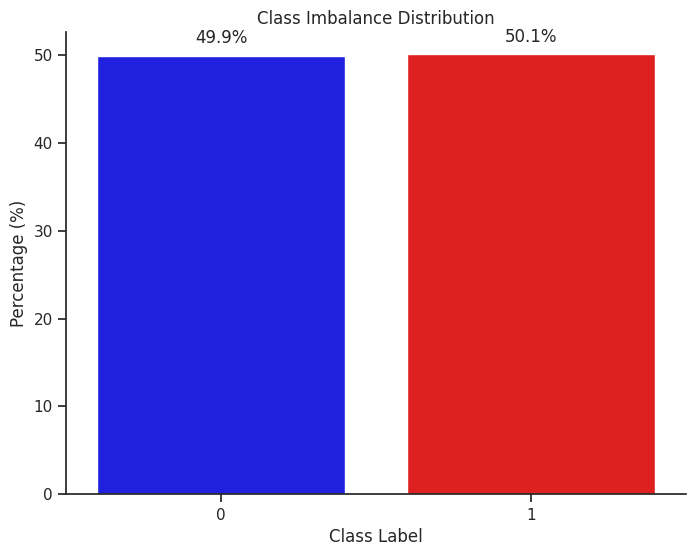

In [ ]:
# checking class imbalance
import matplotlib.pyplot as plt
import seaborn as sns
class_0_var = y_ada[y_ada==0].count() * 100 / y_ada.count()
class_1_var = y_ada[y_ada==1].count() * 100 / y_ada.count()
print(f"Class (0): {class_0_var}%")
print(f"Class (1): {class_1_var}%")

# Create a DataFrame for easier plotting
data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

g = sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

# Access bars and add percentage labels
bars = g.patches  # Get bar handles
for bar, perc in zip(bars, data['Percentage']):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom')


plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.title('Class Imbalance Distribution')
plt.show()

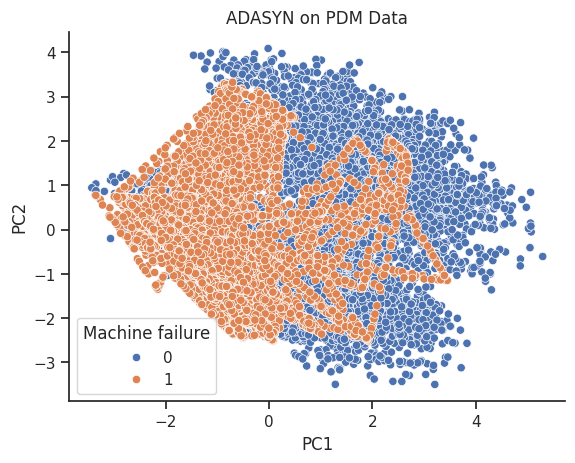

In [ ]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features (m=0, v=1)
x_pca = StandardScaler().fit_transform(X_ada)

# 2D data for Viz using PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y_ada], axis = 1)

# 2D viz (Low Dim) of the features
plt.figure()
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Machine failure')
plt.title("ADASYN on PDM Data")
plt.show()

### SMOTE + Tomek

In [ ]:
# SMOTE + Tomek
from imblearn.combine import SMOTETomek

# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_smtom, y_smtom = smtom.fit_resample(X, y)

print(X_smtom.shape, y_smtom.shape)

(17554, 8) (17554,)


Class (0): 50.0%
Class (1): 50.0%


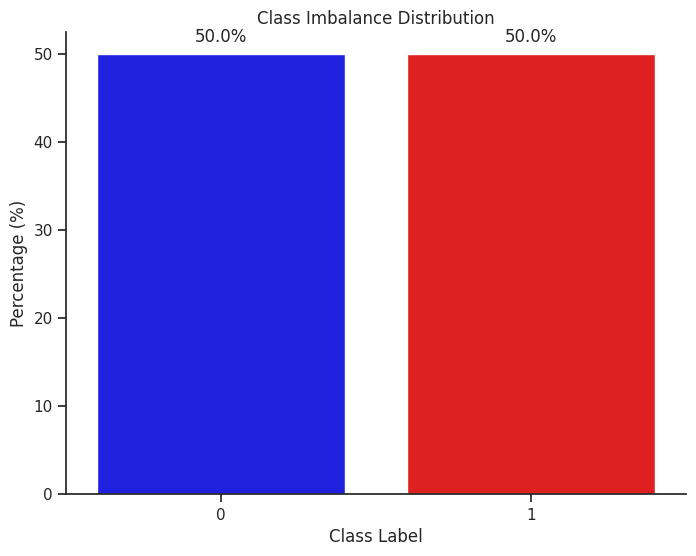

In [ ]:
# checking class imbalance
class_0_var = y_smtom[y_smtom==0].count() * 100 / y_smtom.count()
class_1_var = y_smtom[y_smtom==1].count() * 100 / y_smtom.count()
print(f"Class (0): {class_0_var}%")
print(f"Class (1): {class_1_var}%")

data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

g = sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

# Access bars and add percentage labels
bars = g.patches
for bar, perc in zip(bars, data['Percentage']):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.title('Class Imbalance Distribution')
plt.show()

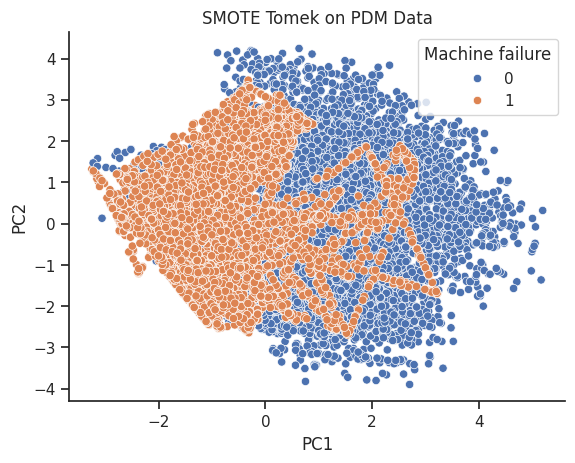

In [ ]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features (m=0, v=1)
x_pca = StandardScaler().fit_transform(X_smtom)

# 2D data for Viz using PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y_smtom], axis = 1)

# 2D viz (Low Dim) of the features
plt.figure()
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Machine failure')
plt.title("SMOTE Tomek on PDM Data")
plt.show()

### SMOTE + ENN

In [ ]:
# SMOTE + ENN
from imblearn.combine import SMOTEENN

# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_smenn, y_smenn = smenn. fit_resample(X, y)

print(X_smenn.shape, y_smenn.shape)

(16564, 8) (16564,)


Class (0): 48.02583916928278%
Class (1): 51.97416083071722%


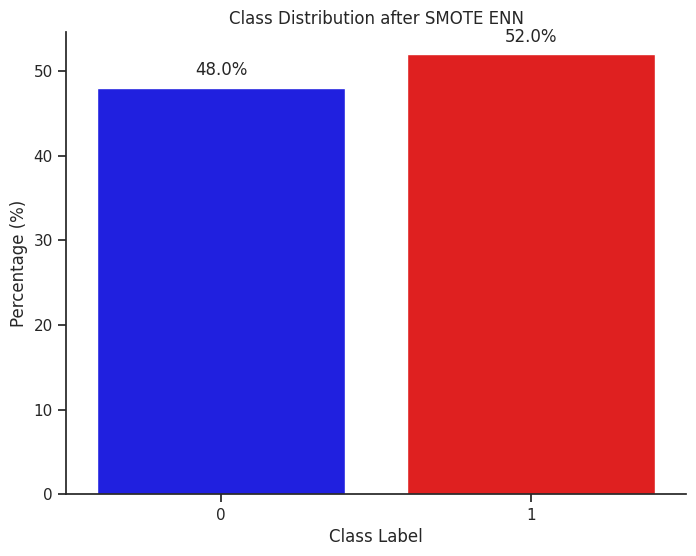

In [ ]:
# checking class imbalance
class_0_var = y_smenn[y_smenn==0].count() * 100 / y_smenn.count()
class_1_var = y_smenn[y_smenn==1].count() * 100 / y_smenn.count()
print(f"Class (0): {class_0_var}%")
print(f"Class (1): {class_1_var}%")

data = pd.DataFrame({'Class': ['0', '1'], 'Percentage': [class_0_var, class_1_var]})
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

g = sns.barplot(x='Class', y='Percentage', data=data, palette=['blue', 'red'])

# Access bars and add percentage labels
bars = g.patches
for bar, perc in zip(bars, data['Percentage']):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution after SMOTE ENN')
plt.show()

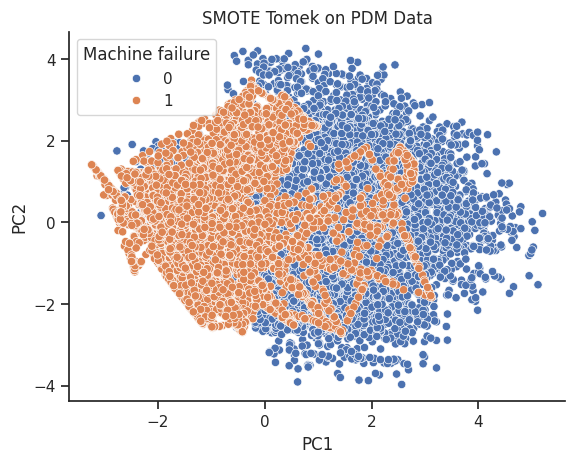

In [ ]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features (m=0, v=1)
x_pca = StandardScaler().fit_transform(X_smenn)

# 2D data for Viz using PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y_smenn], axis = 1)

# 2D viz (Low Dim) of the features
plt.figure()
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Machine failure')
plt.title("SMOTE Tomek on PDM Data")
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Function to perform resampling, calculate class distribution, and PCA
def resample_and_pca(X, y, sampler):
    # Perform resampling
    X_res, y_res = sampler.fit_resample(X, y)

    # Calculate class distribution
    class_0_var = y_res[y_res == 0].count() * 100 / y_res.count()
    class_1_var = y_res[y_res == 1].count() * 100 / y_res.count()

    # Standardize the features
    x_pca = StandardScaler().fit_transform(X_res)
    # 2D data for Viz using PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x_pca)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, y_res.reset_index(drop=True)], axis=1)

    return (class_0_var, class_1_var), finalDf

# Initialize samplers
samplers = {
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'SMOTE-Tomek': SMOTETomek(),
    'SMOTE-ENN': SMOTEENN()
}

# Prepare the figure
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=[
        'SMOTE Class Distribution', 'ADASYN Class Distribution', 'SMOTE-Tomek Class Distribution', 'SMOTE-ENN Class Distribution',
        'SMOTE 2D Data Plot', 'ADASYN 2D Data Plot', 'SMOTE-Tomek 2D Data Plot', 'SMOTE-ENN 2D Data Plot'
    ],
    vertical_spacing=0.2
)

# Define colors
colors = ['blue', 'red']

for idx, (name, sampler) in enumerate(samplers.items()):
    # Resample and get PCA
    (class_0_var, class_1_var), finalDf = resample_and_pca(X, y, sampler)

    # Class distribution plot
    fig.add_trace(
        go.Bar(
            x=['0', '1'],
            y=[class_0_var, class_1_var],
            marker_color=colors,
            text=[f"{class_0_var:.1f}%", f"{class_1_var:.1f}%"],
            textposition='auto'
        ),
        row=1, col=idx+1
    )

    # PCA plot
    fig.add_trace(
        go.Scatter(
            x=finalDf['PC1'],
            y=finalDf['PC2'],
            mode='markers',
            marker=dict(color=finalDf.iloc[:, 2], colorscale=colors, colorbar=dict(title='Class')),
            showlegend=False
        ),
        row=2, col=idx+1
    )

# Update layout
fig.update_layout(
    height=800, width=1600,
    title_text='Oversampling Techniques: Class Distribution and 2D Principal Component Plot',
    title_x=0.5,  # Center the title horizontally
    title_xanchor='center',
    showlegend=False,
    template='plotly_white'
)

# Hide grid lines
for i in range(1, 3):  # Rows
    for j in range(1, 5):  # Columns
        fig.update_xaxes(showgrid=False, showline=True, row=i, col=j)
        fig.update_yaxes(showgrid=False, showline=True, row=i, col=j)

# Show plot
fig.show()


## Train Test Split

https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split


80% - Training

20% - Testing

In [ ]:
X.head(5)

Air temperature  Process temperature  Rotational speed  Torque  Tool wear  \
0            298.1                308.6              1551    42.8          0   
1            298.2                308.7              1408    46.3          3   
2            298.1                308.5              1498    49.4          5   
3            298.2                308.6              1433    39.5          7   
4            298.2                308.7              1408    40.0          9   

   Type_H  Type_L  Type_M  
0     0.0     0.0     1.0  
1     0.0     1.0     0.0  
2     0.0     1.0     0.0  
3     0.0     1.0     0.0  
4     0.0     1.0     0.0

In [ ]:
from sklearn.model_selection import train_test_split

# before resampling ()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# after smote
#X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# after ADASYN
#X_train, X_test, y_train, y_test = train_test_split(X_ada, y_ada, test_size=0.2, random_state=42)

# after SMOTE Tomek
#X_train, X_test, y_train, y_test = train_test_split(X_smtom, y_smtom, test_size=0.2, random_state=42)

# after SMOTE ENN
X_train, X_test, y_train, y_test = train_test_split(X_smenn, y_smenn, test_size=0.2, random_state=42)

## Data Normalisation

### Viz

In [ ]:
import pandas as pd
# Descriptive statistics for X
X_desc = X.describe()


# Display the DataFrame
X_desc


Air temperature  Process temperature  Rotational speed       Torque  \
count      8992.000000          8992.000000       8992.000000  8992.000000   
mean        299.982529           309.989413       1513.409698    40.679059   
std           1.970984             1.458625        124.871223     8.518142   
min         295.300000           305.700000       1181.000000    20.100000   
25%         298.300000           308.800000       1423.000000    34.400000   
50%         300.000000           310.000000       1497.000000    40.500000   
75%         301.500000           311.000000       1591.000000    46.700000   
max         304.500000           313.800000       1911.000000    68.900000   

         Tool wear       Type_H       Type_L       Type_M  
count  8992.000000  8992.000000  8992.000000  8992.000000  
mean    107.858430     0.066170     0.626446     0.307384  
std      62.959525     0.248593     0.483774     0.461436  
min       0.000000     0.000000     0.000000     0.000000  
25%      54.000000     0.000000     0.000000     0.000000  
50%     108.000000     0.000000     1.000000     0.000000  
75%     162.000000     0.000000     1.000000     1.000000  
max     251.000000     1.000000     1.000000     1.000000

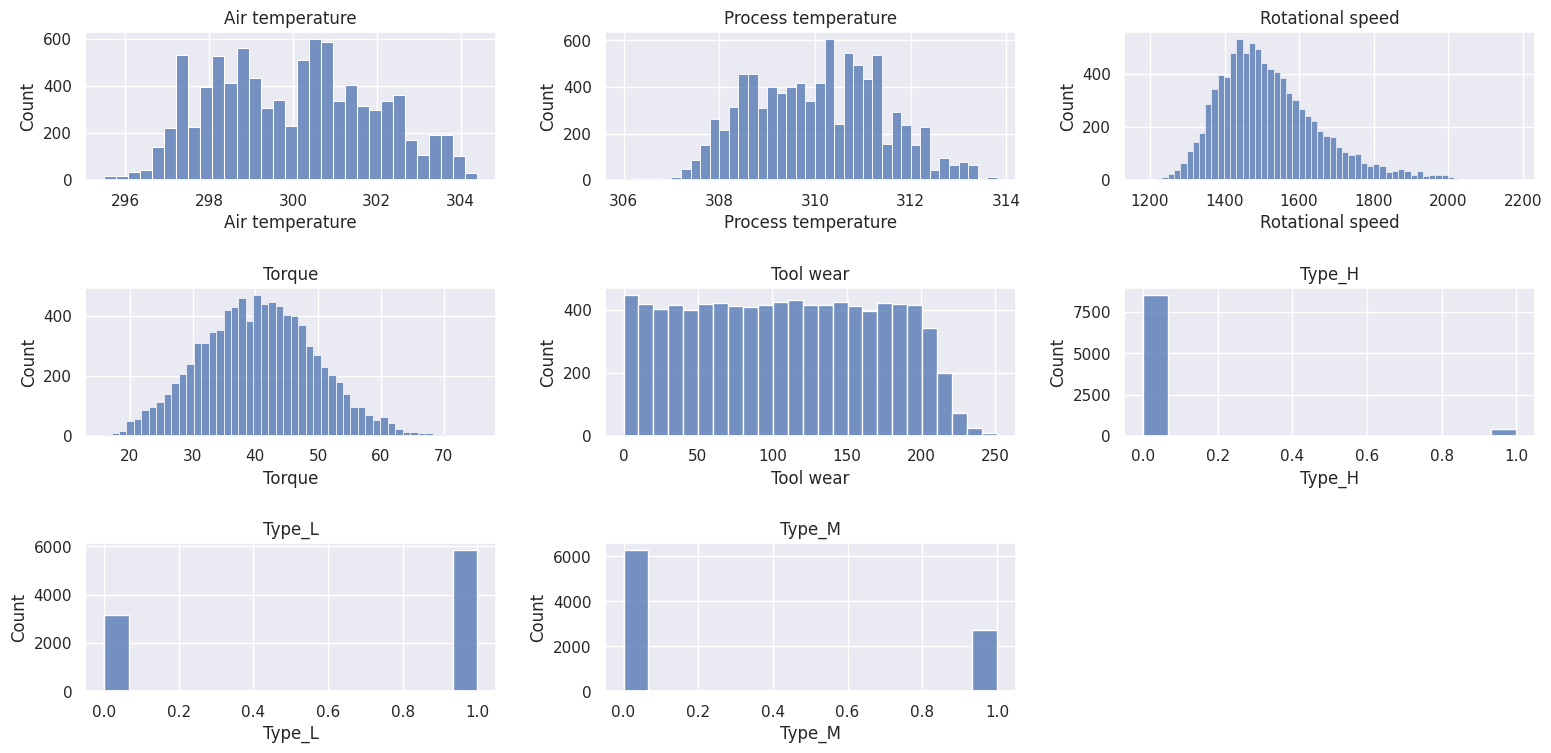

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()
features = X.columns

# Calculate the number of rows and columns
num_features = len(features)
num_cols = 3
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Flatten axes array if there are multiple rows
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = np.array([axes])

# Plot each feature
for i, feature in enumerate(features):
    sns.histplot(ax=axes[i], x=X[feature])
    axes[i].set_title(feature)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)
plt.show()


https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

### Scaling

https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data



In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()

norm_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
norm_X_train

Air temperature  Process temperature  Rotational speed    Torque  \
0             1.320289             0.967003         -0.822656  0.762696   
1            -1.580451            -0.703612          0.877310 -0.825909   
2             0.862278             1.185337         -0.019461 -0.094525   
3            -1.224220            -1.018436         -0.931828 -0.104973   
4            -0.690008            -1.342519          0.479612 -1.401700   
...                ...                  ...               ...       ...   
13246        -0.419433            -0.655550         -0.417159 -0.323647   
13247         0.692194             0.529799         -0.074047 -0.209839   
13248         0.353376             0.949218          3.013965 -2.320023   
13249        -1.936683            -1.884204          0.885108 -0.616942   
13250         0.717154            -0.238490         -0.074047 -0.120675   

       Tool wear    Type_H    Type_L    Type_M  
0      -1.767018 -0.230853  0.150011 -0.041562  
1      -1.583367 -0.230853  0.684008 -0.609966  
2       0.281405  4.685499 -1.679155 -0.609966  
3      -0.453202 -0.230853  0.684008 -0.609966  
4       1.100774 -0.230853  0.684008 -0.609966  
...          ...       ...       ...       ...  
13246   1.227917  0.269503 -1.679155  1.649459  
13247   1.072520 -0.230853  0.684008 -0.609966  
13248   1.171409 -0.230853 -1.679155  1.905464  
13249  -0.114153 -0.230853  0.684008 -0.609966  
13250   1.340934 -0.230853  0.684008 -0.609966  

[13251 rows x 8 columns]

In [ ]:
norm_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
norm_X_test

Air temperature  Process temperature  Rotational speed    Torque  \
0           -0.206416             0.004744          0.612178  0.323409   
1           -0.383377             0.298884         -1.243748  1.686177   
2           -0.969769            -0.073962          0.830522 -0.815461   
3            1.065838             1.736280         -0.222209  0.678653   
4           -0.613538            -0.782318         -0.144229 -0.345285   
...               ...                  ...               ...       ...   
3308         1.138451             0.698943         -0.853848  0.531198   
3309         1.270356             1.060689         -0.869444  0.347346   
3310        -0.155526            -0.546199          0.775936 -0.784116   
3311        -1.173330            -0.624905          0.924098 -1.024428   
3312         0.506046             0.476981          0.752542 -1.170705   

      Tool wear    Type_H    Type_L    Type_M  
0     -1.654002 -0.230853  0.684008 -0.609966  
1      1.058393 -0.230853 -0.722473  0.887139  
2     -1.244317 -0.230853  0.684008 -0.609966  
3     -1.018284 -0.230853  0.684008 -0.609966  
4     -1.555113 -0.230853  0.684008 -0.609966  
...         ...       ...       ...       ...  
3308   0.549819 -0.230853  0.684008 -0.609966  
3309   1.072520 -0.230853 -1.209483  1.405530  
3310  -1.272571 -0.230853  0.684008 -0.609966  
3311   0.083626 -0.230853  0.684008 -0.609966  
3312   0.154261 -0.230853 -1.679155  1.905464  

[3313 rows x 8 columns]

## Feature Correlation

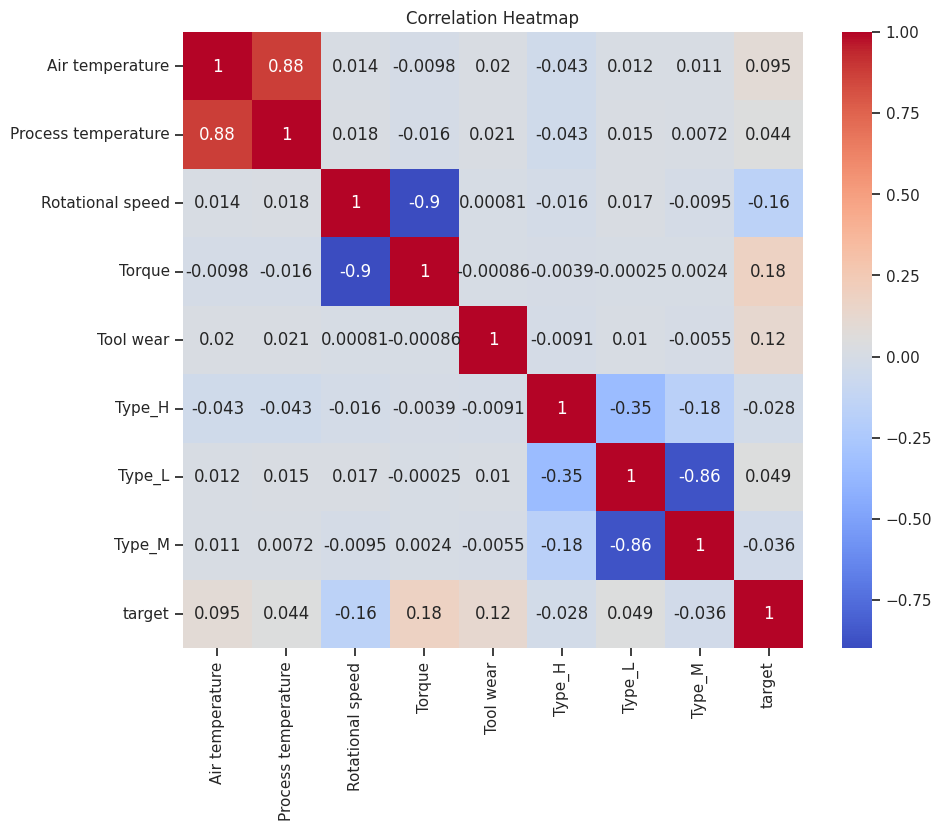

In [ ]:
# Checking Correlation
copyX = X
copyX['target'] = y
plt.figure(figsize=(10, 8))
cm = X.corr()
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## PCA Feature Reduction

https://www.geeksforgeeks.org/principal-component-analysis-pca/

In [ ]:
from sklearn.decomposition import PCA

col = ['PC1', 'PC2', 'PC3', 'PC4','PC5']
pca = PCA(0.95)

principalComponents = pca.fit_transform(norm_X_train)

X_train_pca = pd.DataFrame(data = principalComponents)
X_train_pca.columns = col
X_train_pca

PC1       PC2       PC3       PC4       PC5
0     -0.547514  1.522671 -0.549579 -0.210537  0.248769
1     -1.826726 -0.324778 -0.395604  0.037521  0.380051
2     -1.749040  0.200927  0.176157  0.111193  0.070067
3     -1.286333 -1.277785 -0.807717 -0.151364  0.462738
4     -1.315570  0.316032  0.424441  0.023597 -1.345566
...         ...       ...       ...       ...       ...
13251 -1.282535 -1.067710 -0.502208 -0.064666  0.935850
13252 -3.053646  1.288885  0.208693  0.434543  1.011765
13253  2.621621 -0.152810  4.006507 -0.070705 -0.159183
13254  1.871475 -2.778695  0.542102 -0.551620 -0.207144
13255 -1.959201  1.164788  0.697440  0.211654 -1.273601

[13256 rows x 5 columns]

In [ ]:
print(pca.explained_variance_ratio_)
print('Total Explained Variance of PCs:', f"{round(pca.explained_variance_ratio_.sum()*100, 2)}%")

[0.29355925 0.24478909 0.18756851 0.13293907 0.11377139]
Total Explained Variance of PCs: 97.26%


In [ ]:
X_test_pca = pca.transform(norm_X_test)
X_test_pca = pd.DataFrame(data = X_test_pca)
X_test_pca.columns = col
X_test_pca.head()

PC1       PC2       PC3       PC4       PC5
0  0.411909  1.965849 -1.144236 -0.478124  0.383458
1 -2.497420  1.205708  0.652445  0.386105  0.860559
2 -0.087247  4.111042 -0.057829 -0.173221  0.113389
3 -0.405043  2.376059 -0.974793 -0.243602  1.344595
4 -1.172983  0.201670  0.460730  0.008115 -1.254032

## Classification Models

1. Logistic Regression
2. Gradient Boosted Trees
3. Random Forest

### Model Without Scaling and Resampling

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, log_loss

def model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, cm_df):
  confusion_matrices = {}
  for model_name, model in models.items():
    # Training accuracy
    y_train_pred = model.predict(norm_X_train)
    training_accuracy = accuracy_score(y_train, y_train_pred)

    # Testing accuracy
    y_test_pred = model.predict(norm_X_test)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Metrics
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    confusion = confusion_matrix(y_test, y_test_pred)
    confusion_matrices[model_name] = confusion

    metrics = {
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
    # Main Data Frame
    df = pd.DataFrame(metrics, index=[0])
    frame[model_name] = df.T
    frame.index = metrics.keys()
  # Confusion Matrix
  cm_viz(confusion_matrices)
  return frame, cm_df

def cm_viz(confusion_matrices):
    num_models = len(confusion_matrices)
    plt.figure()
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5))
    if num_models == 1:
        axes = [axes]
    for ax, (model_name, confusion) in zip(axes, confusion_matrices.items()):
        sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt="d", ax=ax)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(f"{model_name}")
    plt.tight_layout()
    plt.show()
    print("\n")

#### Without Any Scaling

<Figure size 640x480 with 0 Axes>

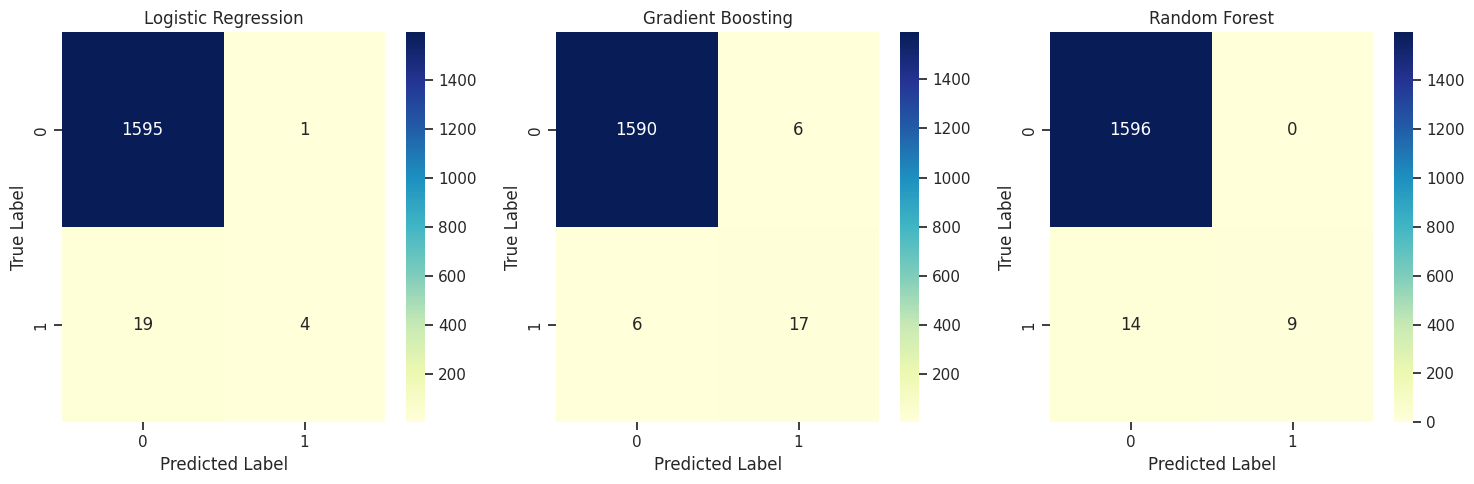

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.977908           0.996447       0.999228
Testing Accuracy              0.987647           0.992588       0.991353
Precision                     0.800000           0.739130       1.000000
Recall                        0.173913           0.739130       0.391304
F1-Score                      0.285714           0.739130       0.562500

In [ ]:
# Model without scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression().fit(X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_normal, cm = model_comp(models, X_train, y_train, X_test, y_test, frame, conf_df)
frame_normal

The comparison from the three models without any data scaling depicts that the Recall is very low. There are more False Negatives. But Gradient Boosting seems to have a trade-off, having same number of False Negative and False Positives.

#### With Min-Max Scaling

<Figure size 640x480 with 0 Axes>

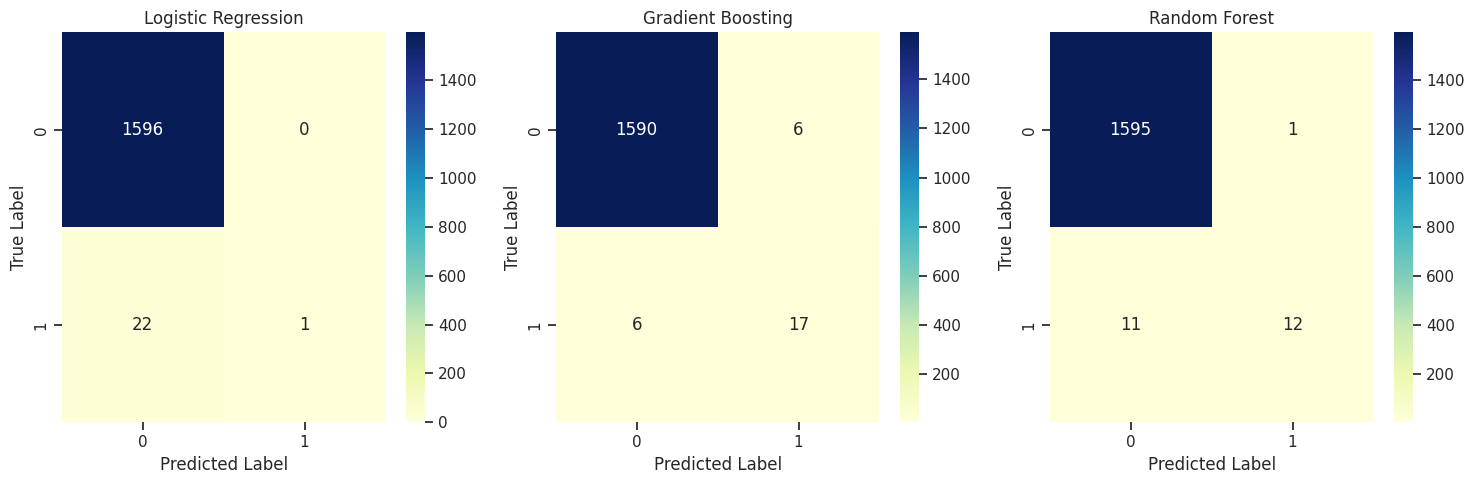

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.977599           0.996447       0.998919
Testing Accuracy              0.986411           0.992588       0.992588
Precision                     1.000000           0.739130       0.923077
Recall                        0.043478           0.739130       0.521739
F1-Score                      0.083333           0.739130       0.666667

In [ ]:
# with min max scaling alone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_min_max, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_min_max


#### With Standard Scaling

<Figure size 640x480 with 0 Axes>

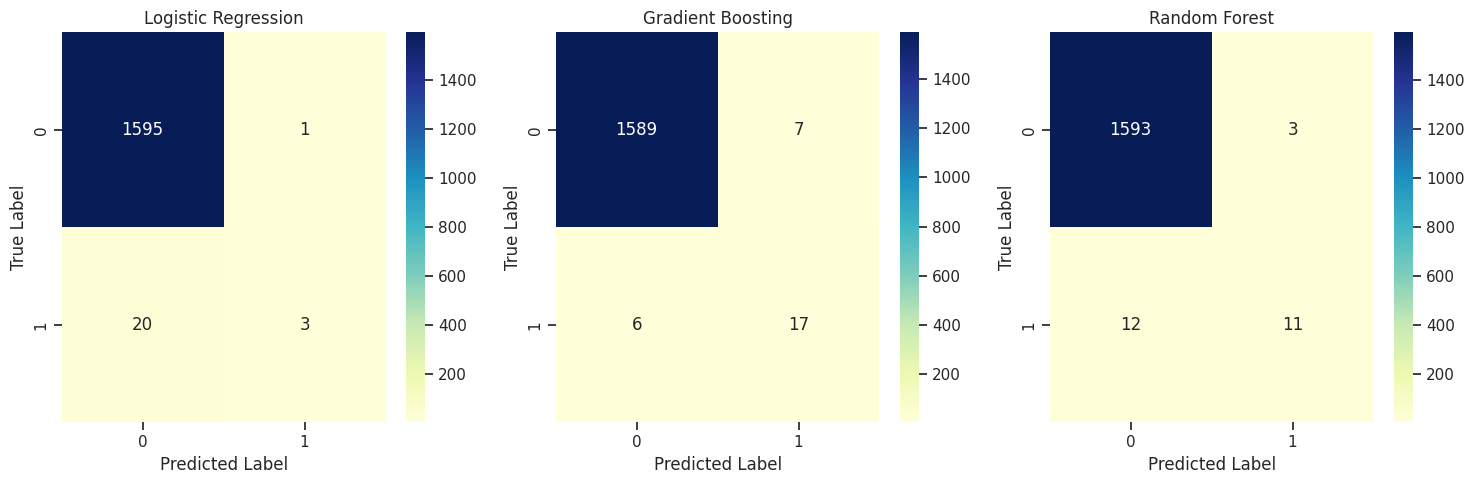

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.977599           0.996447       0.998919
Testing Accuracy              0.987029           0.991970       0.990735
Precision                     0.750000           0.708333       0.785714
Recall                        0.130435           0.739130       0.478261
F1-Score                      0.222222           0.723404       0.594595

In [ ]:
# After standard scaling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_standard, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_standard

#### Viz Result

<Figure size 640x480 with 0 Axes>

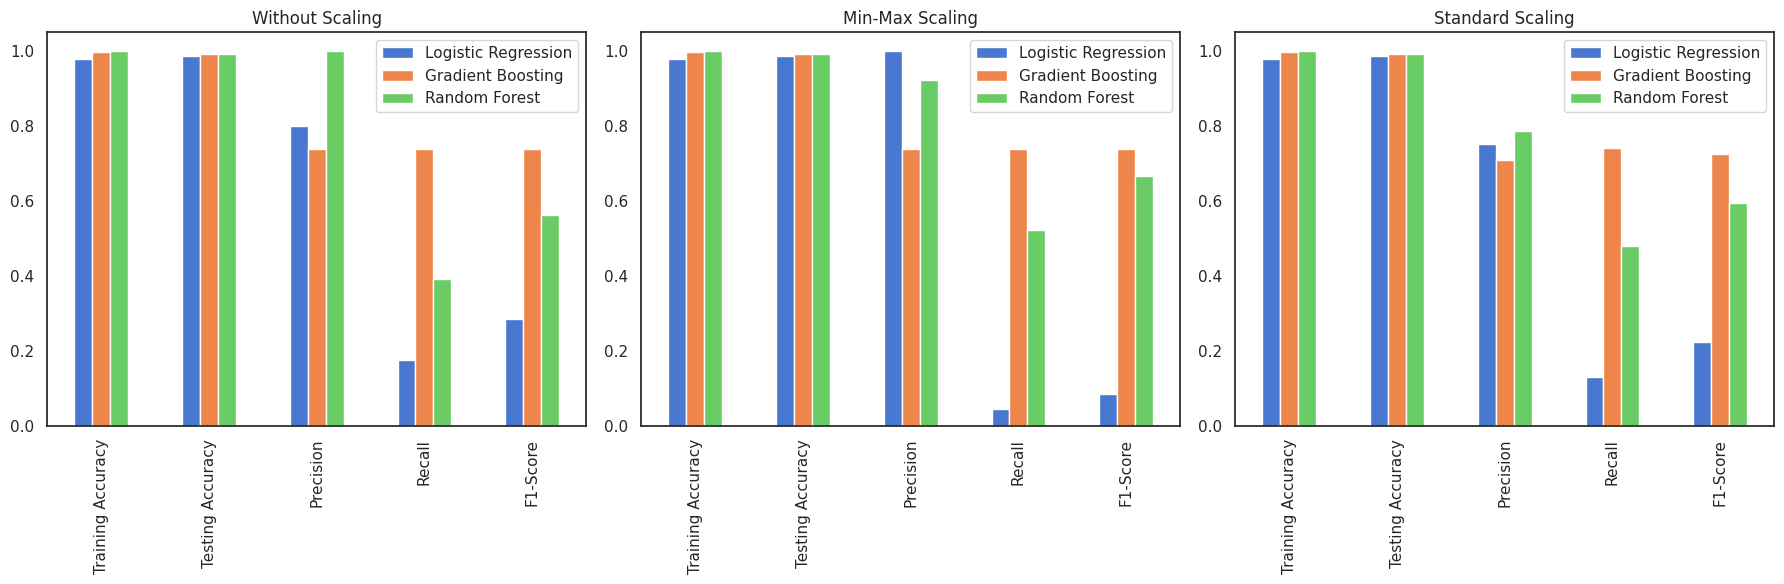

In [ ]:
# Viz
plt.figure()
sns.set_style("white")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

frame_normal.plot(kind='bar', ax=axes[0], color=palette)
axes[0].set_title('Without Scaling')

frame_min_max.plot(kind='bar', ax=axes[1], color=palette)
axes[1].set_title('Min-Max Scaling')

frame_standard.plot(kind='bar', ax=axes[2], color=palette)
axes[2].set_title('Standard Scaling')

plt.tight_layout()
plt.show()

### Model with scaling and Resampling

#### SMOTE

<Figure size 640x480 with 0 Axes>

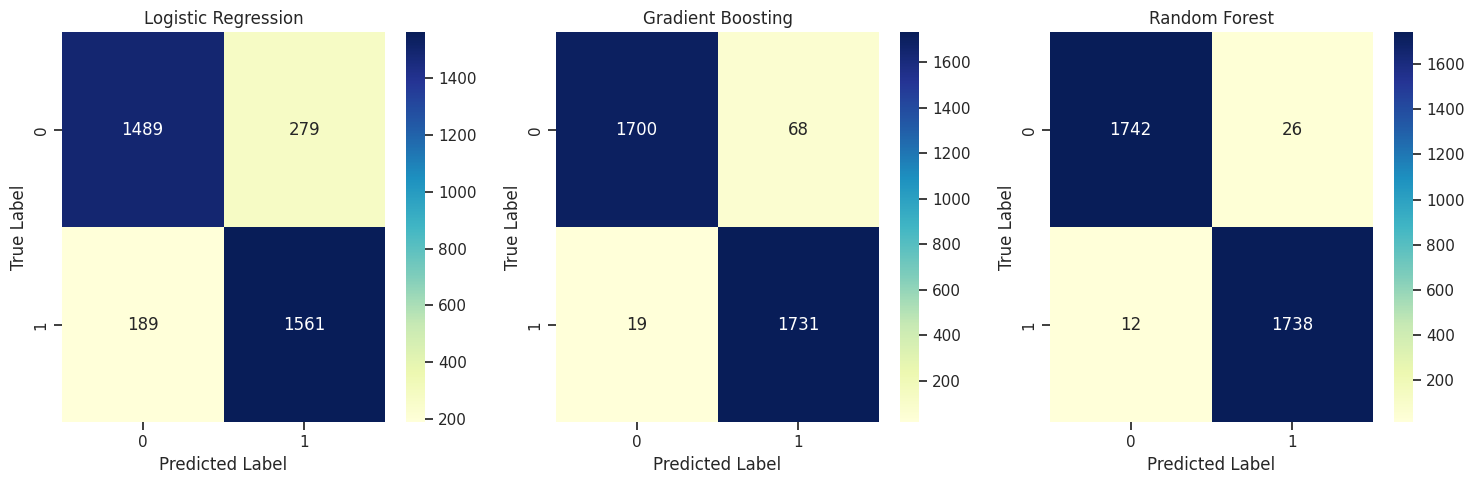

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.866790           0.980239       0.999929
Testing Accuracy              0.866970           0.975270       0.989198
Precision                     0.848370           0.962201       0.985261
Recall                        0.892000           0.989143       0.993143
F1-Score                      0.869638           0.975486       0.989186

In [ ]:
# After Standard Scaling -> SMOTE
models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_smote, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_smote

#### After ADASYN

<Figure size 640x480 with 0 Axes>

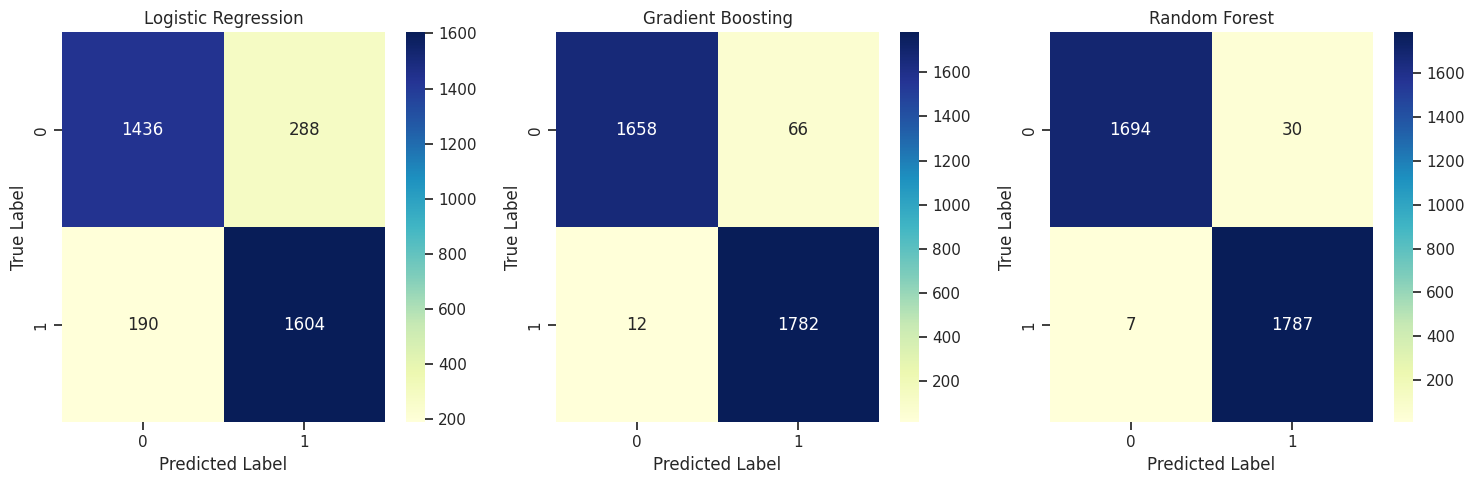

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.861711           0.980458       1.000000
Testing Accuracy              0.864127           0.977828       0.989483
Precision                     0.847780           0.964286       0.983489
Recall                        0.894091           0.993311       0.996098
F1-Score                      0.870320           0.978583       0.989754

In [ ]:
# After ADASYN and Standard Scaling
models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_adasyn, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_adasyn

#### After SMOTE Tomek

<Figure size 640x480 with 0 Axes>

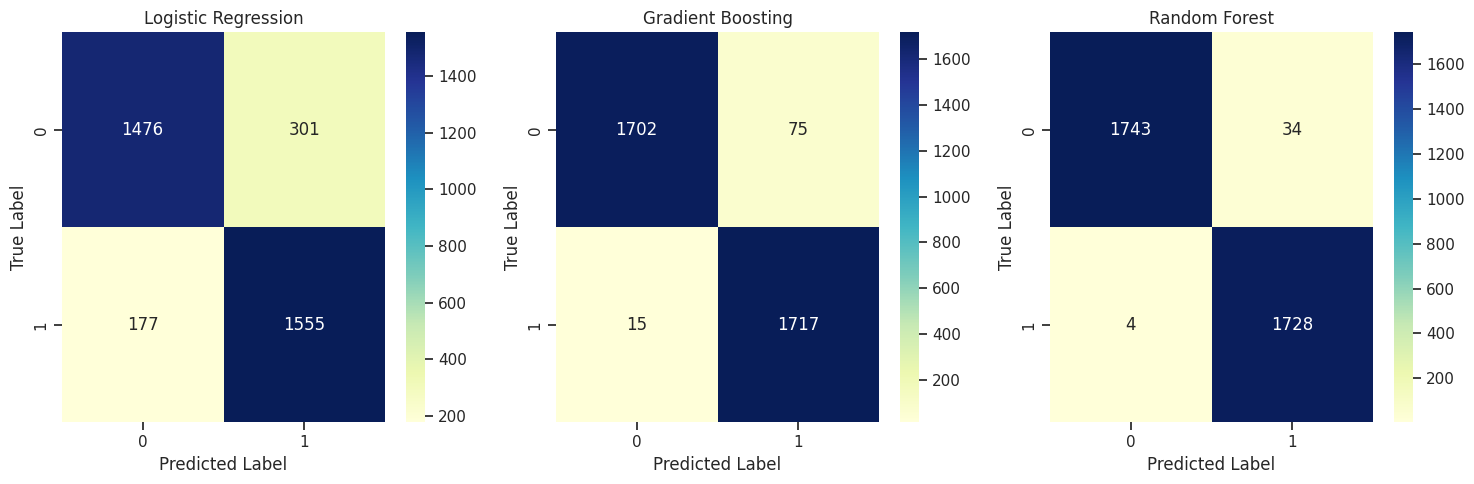

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.868543           0.979480       0.999786
Testing Accuracy              0.863779           0.974352       0.989171
Precision                     0.837823           0.958147       0.980704
Recall                        0.897806           0.991339       0.997691
F1-Score                      0.866778           0.974461       0.989124

In [ ]:
# After Standard Scaling & SMOTE Tomek
models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_smoteT, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_smoteT

#### SMOTE ENN

<Figure size 640x480 with 0 Axes>

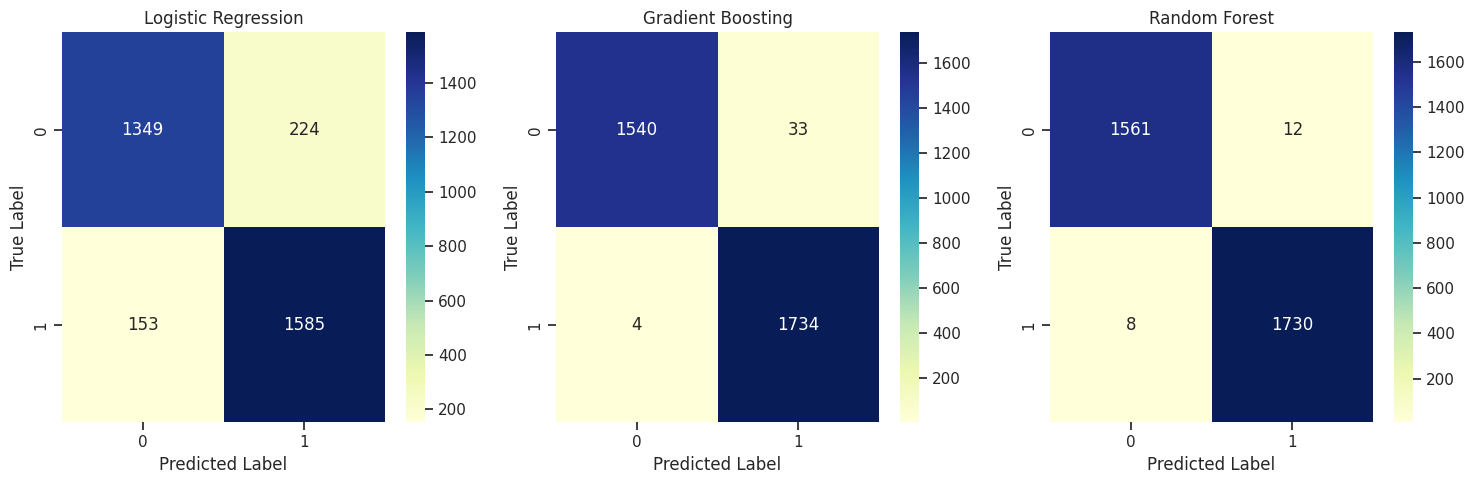

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.891037           0.992449       0.999849
Testing Accuracy              0.886137           0.988825       0.993960
Precision                     0.876175           0.981324       0.993111
Recall                        0.911968           0.997699       0.995397
F1-Score                      0.893713           0.989444       0.994253

In [ ]:
# After SMOTE ENN & Standard Scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression().fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier().fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(n_estimators=20).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_smoteenn, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_smoteenn

<Figure size 640x480 with 0 Axes>

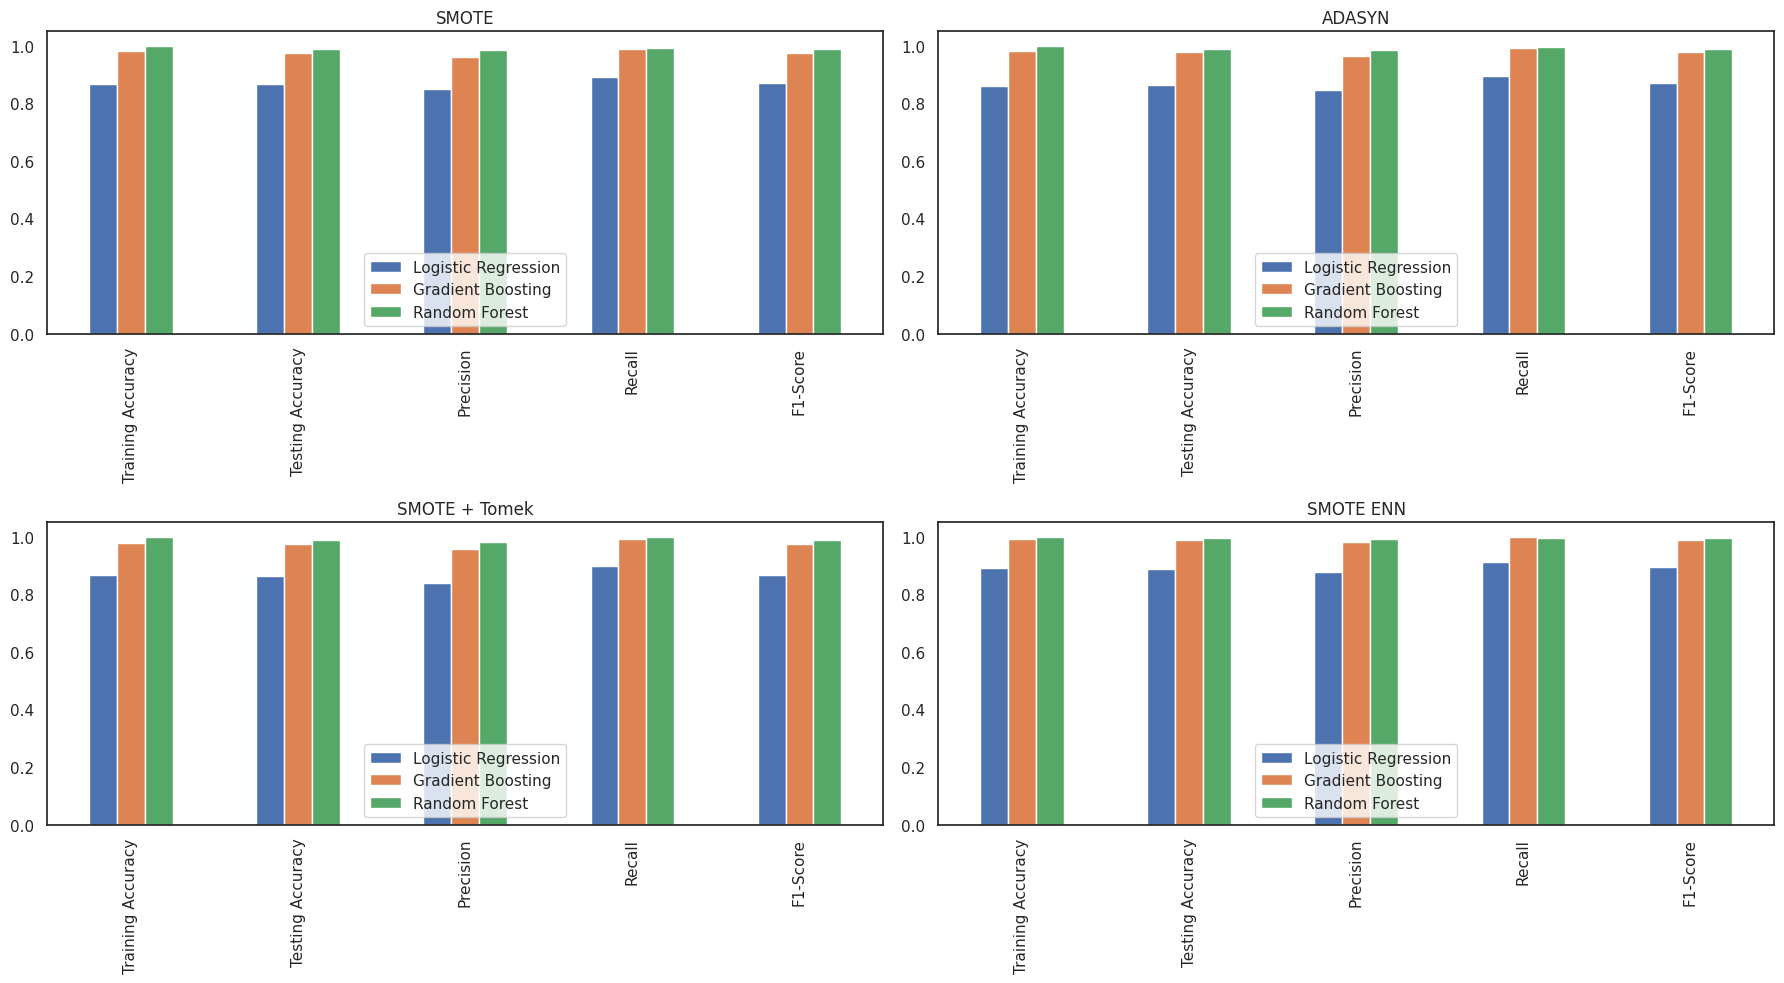

In [ ]:
# Viz
plt.figure()
sns.set_style("white")
palette = sns.color_palette("deep")
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

frame_smote.plot(kind='bar', ax=axes[0,0], color=palette)
axes[0,0].set_title('SMOTE')

frame_adasyn.plot(kind='bar', ax=axes[0,1], color=palette)
axes[0,1].set_title('ADASYN')

frame_smoteT.plot(kind='bar', ax=axes[1,0], color=palette)
axes[1,0].set_title('SMOTE + Tomek')

frame_smoteenn.plot(kind='bar', ax=axes[1,1], color=palette)
axes[1,1].set_title('SMOTE ENN')

plt.tight_layout()
plt.show()

Random Forest outperforms other two models in almost every methods of resampling. Particularly, SMOTE ENN proved to improve all the metrics during the model training phase

### Hyper parameter tuning

#### Grid Search for Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
# After SMOTE ENN & Standard Scaling
# Hyperparameter tuning for Logistic Regression using Grid Search
param_grid_log_reg = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

log_reg = LogisticRegression()
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(norm_X_train, y_train)
best_log_reg = grid_search_log_reg.best_estimator_


# Define and train models with hyperparameters
models = {
    'Logistic Regression': best_log_reg,
}

In [ ]:
print("Best parameters for Logistic Regression:")
print(grid_search_log_reg.best_params_)

Best parameters for Logistic Regression:
{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


#### Grid search for Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter tuning for Gradient Boosting using Grid Search
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [ 4, 5],
}

gb = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(norm_X_train, y_train)
best_gb = grid_search_gb.best_estimator_

# Define and train models with hyperparameters
models = {
    'Gradient Boosting': best_gb,
}

In [ ]:
print("\nBest parameters for Gradient Boosting:")
print(grid_search_gb.best_params_)


Best parameters for Gradient Boosting:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


#### Grid search for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning for Random Forest using Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(norm_X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Define and train models with hyperparameters
models = {
    'Random Forest': best_rf,
}

In [ ]:
print("\nBest parameters for Random Forest:")
print(grid_search_rf.best_params_)


Best parameters for Random Forest:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
import pandas as pd

# Best hyperparameters
best_params = {
    'Logistic Regression': {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'},
    'Gradient Boosting': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200},
    'Random Forest': {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
}

# Create a DataFrame
params_df = pd.DataFrame(best_params).transpose()
params_df.index.name = 'Model'
params_df.reset_index(inplace=True)

# Display the DataFrame
print(params_df)

                 Model     C max_iter penalty solver learning_rate max_depth  \
0  Logistic Regression  0.01      100      l2  lbfgs           NaN       NaN   
1    Gradient Boosting   NaN      NaN     NaN    NaN           0.2       5.0   
2        Random Forest   NaN      NaN     NaN    NaN           NaN        20   

  n_estimators bootstrap min_samples_leaf min_samples_split  
0          NaN       NaN              NaN               NaN  
1        200.0       NaN              NaN               NaN  
2          200     False                1                 2  


#### Tuning the models

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import plotly.graph_objs as go

def model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, cm_df):
    confusion_matrices = {}
    roc_traces = []

    for model_name, model in models.items():
        # Training accuracy
        y_train_pred = model.predict(norm_X_train)
        training_accuracy = accuracy_score(y_train, y_train_pred)

        # Testing accuracy
        y_test_pred = model.predict(norm_X_test)
        testing_accuracy = accuracy_score(y_test, y_test_pred)

        # Metrics
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        confusion = confusion_matrix(y_test, y_test_pred)
        confusion_matrices[model_name] = confusion

        # ROC and AUC
        if hasattr(model, "predict_proba"):
            y_test_proba = model.predict_proba(norm_X_test)[:, 1]
        else:
            y_test_proba = model.decision_function(norm_X_test)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)

        # Add trace for ROC curve
        roc_traces.append(
            go.Scatter(
                x=fpr, y=tpr, mode='lines', name=f'{model_name} (AUC = {roc_auc:.2f})'
            )
        )

        metrics = {
            "Training Accuracy": training_accuracy,
            "Testing Accuracy": testing_accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

        # Main Data Frame
        df = pd.DataFrame(metrics, index=[0])
        frame[model_name] = df.T
        frame.index = metrics.keys()

    # Plot ROC curves using Plotly
    fig = go.Figure()
    for trace in roc_traces:
        fig.add_trace(trace)

    fig.add_trace(
        go.Scatter(
            x=[0, 1], y=[0, 1], mode='lines', name='Random Chance', line=dict(dash='dash')
        )
    )

    fig.update_layout(
        title='Receiver Operating Characteristic (ROC) Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        showlegend=True,
        template='plotly_white',
        width=800,
        height=600,

    )

    fig.show()

    # Confusion Matrix
    cm_viz(confusion_matrices)
    return frame, cm_df

def cm_viz(confusion_matrices):
    num_models = len(confusion_matrices)
    plt.figure()
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5))
    if num_models == 1:
        axes = [axes]
    for ax, (model_name, confusion) in zip(axes, confusion_matrices.items()):
        sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt="d", ax=ax)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(f"{model_name}")
    plt.tight_layout()
    plt.show()
    print("\n")


<Figure size 640x480 with 0 Axes>

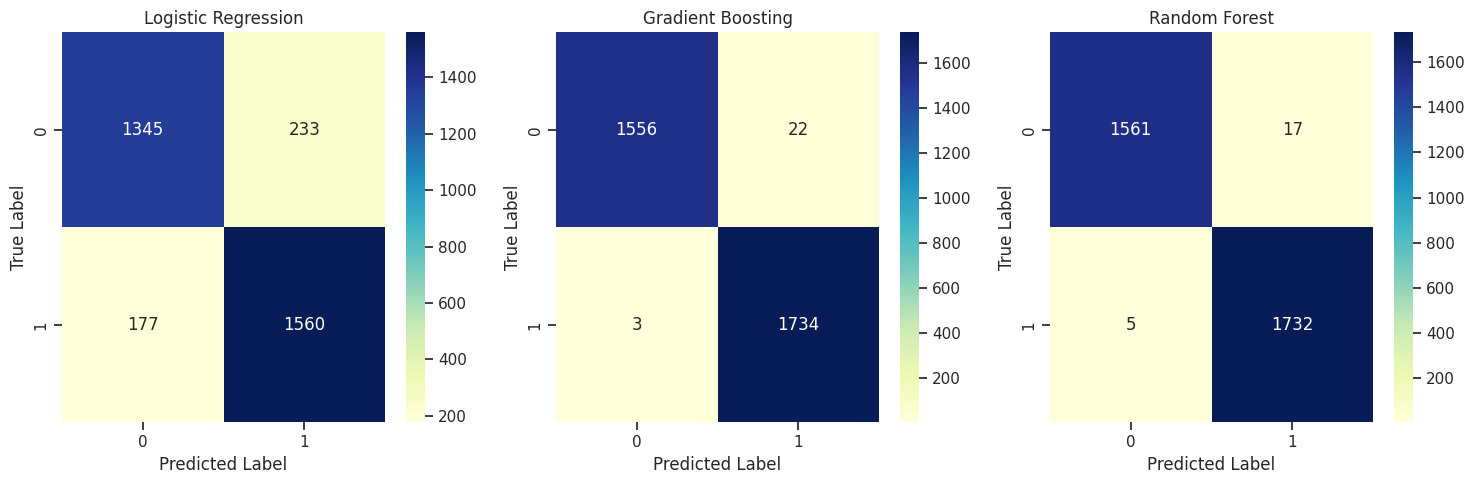

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.882468           0.997284       0.998868
Testing Accuracy              0.876320           0.992459       0.993363
Precision                     0.870050           0.987472       0.990280
Recall                        0.898100           0.998273       0.997121
F1-Score                      0.883853           0.992843       0.993689

In [ ]:
# After SMOTE ENN & Standard Scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression(
    C=0.01, max_iter=100, penalty='l2', solver='lbfgs'
).fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
    max_features= 'sqrt',
    max_depth=5,
    n_estimators=100
).fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_tuned, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_tuned

<Figure size 640x480 with 0 Axes>

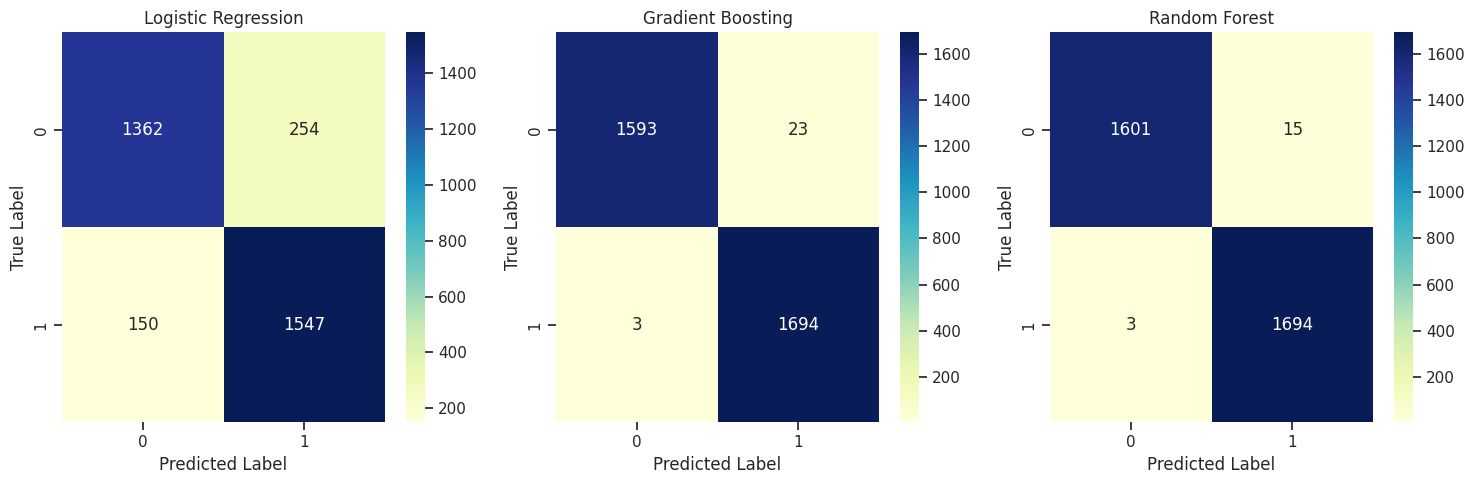

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.878877           0.997434       0.999170
Testing Accuracy              0.878056           0.992152       0.994567
Precision                     0.858967           0.986605       0.991223
Recall                        0.911609           0.998232       0.998232
F1-Score                      0.884505           0.992384       0.994715

In [ ]:
# After SMOTE ENN & Standard Scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression(
    C=0.01, max_iter=100, penalty='l2', solver='lbfgs'
).fit(norm_X_train, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
    max_features= 'sqrt',
    max_depth=5,
    n_estimators=100
).fit(norm_X_train, y_train)
models['Random Forest'] = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
).fit(norm_X_train, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_tuned, cm = model_comp(models, norm_X_train, y_train, norm_X_test, y_test, frame, conf_df)
frame_tuned

In [ ]:
frame_tuned['Metrics']=frame_tuned.index
frame_tuned.reset_index(drop=True, inplace=True)
frame_tuned

Logistic Regression  Gradient Boosting  Random Forest            Metrics
0             0.882468           0.997284       0.998868  Training Accuracy
1             0.876320           0.992459       0.993363   Testing Accuracy
2             0.870050           0.987472       0.990280          Precision
3             0.898100           0.998273       0.997121             Recall
4             0.883853           0.992843       0.993689           F1-Score

In [ ]:
import plotly.express as px

# Melt the DataFrame to have 'Metrics' and 'Models' columns
frame_tuned_melted = frame_tuned.melt(id_vars='Metrics', var_name='Models', value_name='Scores')

# Create the bar plot
fig = px.bar(frame_tuned_melted, x='Metrics', y='Scores', color='Models', barmode='group',
             title='Model Performance After Hyperparameter Tuning',
             color_discrete_sequence=px.colors.qualitative.D3)

# Customize the layout
fig.update_layout(
    legend=dict(font=dict(size=12)),
    xaxis_title='Metrics',
    yaxis_title='Scores',
    legend_title='Models',
    font=dict(size=14),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, showline=True),
    template='plotly_white',
)

# Show the plot
fig.show()

### K-fold Cross Validation

https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/

In [ ]:
from sklearn.model_selection import StratifiedKFold

train_accuracy_list = {'Logistic Regression': [], 'Gradient Boosting': [], 'Random Forest': []}
test_accuracy_list = {'Logistic Regression': [], 'Gradient Boosting': [], 'Random Forest': []}
precision_list = {'Logistic Regression': [], 'Gradient Boosting': [], 'Random Forest': []}
recall_list = {'Logistic Regression': [], 'Gradient Boosting': [], 'Random Forest': []}
f1_list = {'Logistic Regression': [], 'Gradient Boosting': [], 'Random Forest': []}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# X is the feature set and y is the target
for train_index, val_index in skf.split(X,y):
    norm_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    #print("Train:", train_index, "Validation:", val_index)
    X_train, X_test = norm_X.iloc[train_index], norm_X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

    scaler = preprocessing.StandardScaler()

    models = {}
    models['Logistic Regression'] = LogisticRegression(
    C=0.01, max_iter=100, penalty='l2', solver='lbfgs'
    ).fit(X_train, y_train)
    models['Gradient Boosting'] = GradientBoostingClassifier().fit(X_train, y_train)
    models['Random Forest'] = RandomForestClassifier(
        n_estimators=20
    ).fit(X_train, y_train)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        train_accuracy_list[model_name].append(model.score(X_train, y_train))
        test_accuracy_list[model_name].append(accuracy_score(y_test, y_pred))
        precision_list[model_name].append(precision_score(y_test, y_pred))
        recall_list[model_name].append(recall_score(y_test, y_pred))
        f1_list[model_name].append(f1_score(y_test, y_pred))

results = {}
for model_name in models.keys():
    results[model_name] = {
        'Training Accuracy': (np.mean(train_accuracy_list[model_name]), np.std(train_accuracy_list[model_name])),
        'Testing Accuracy': (np.mean(test_accuracy_list[model_name]), np.std(test_accuracy_list[model_name])),
        'Precision': (np.mean(precision_list[model_name]), np.std(precision_list[model_name])),
        'Recall': (np.mean(recall_list[model_name]), np.std(recall_list[model_name])),
        'F1-Score': (np.mean(f1_list[model_name]), np.std(f1_list[model_name]))
    }

results2 = {}
for i, model_name in enumerate(models):
    results2[model_name] = {
        'Training Accuracy': (max(train_accuracy_list[model_name]), i),
        'Testing Accuracy': (max(test_accuracy_list[model_name]), i),
        'Precision': (max(precision_list[model_name]), i),
        'Recall': (max(recall_list[model_name]), i),
        'F1-Score': (max(f1_list[model_name]), i)
    }

# results
print("Average Model Performance:")
results_df = pd.DataFrame(results)
print(results_df)
print("\n")
print("Best Model:")
results2_df = pd.DataFrame(results2)
print(results2_df)


Average Model Performance:
                                            Logistic Regression  \
Training Accuracy    (0.977869218525208, 5.500452278452325e-05)   
Testing Accuracy   (0.9778692401723612, 0.00022006565565333853)   
Precision                                            (0.0, 0.0)   
Recall                                               (0.0, 0.0)   
F1-Score                                             (0.0, 0.0)   

                                              Gradient Boosting  \
Training Accuracy  (0.9958852320706416, 0.00045346077977503646)   
Testing Accuracy    (0.9891015339754319, 0.0014321685720761147)   
Precision             (0.8769844349199187, 0.04357792626552291)   
Recall                (0.5932051282051282, 0.07011027286784874)   
F1-Score             (0.7045076746666933, 0.049302110656514894)   

                                                  Random Forest  
Training Accuracy  (0.9995273568760534, 0.00011120958338182872)  
Testing Accuracy    (0.986098753416

K-fold Cross Validation doesnt seem to work well with 10, 5, 4, and 2 folds. Even though the accuracy seems to be really high splitting the data into K folds and validatiion process reduces the recall tremendously which is a big problem.

### Model after PCA

In [ ]:
from sklearn.decomposition import PCA

col = ['PC1', 'PC2', 'PC3', 'PC4','PC5']
pca = PCA(0.95)

principalComponents = pca.fit_transform(norm_X_train)

X_train_pca = pd.DataFrame(data = principalComponents)
X_train_pca.columns = col
X_train_pca

<Figure size 640x480 with 0 Axes>

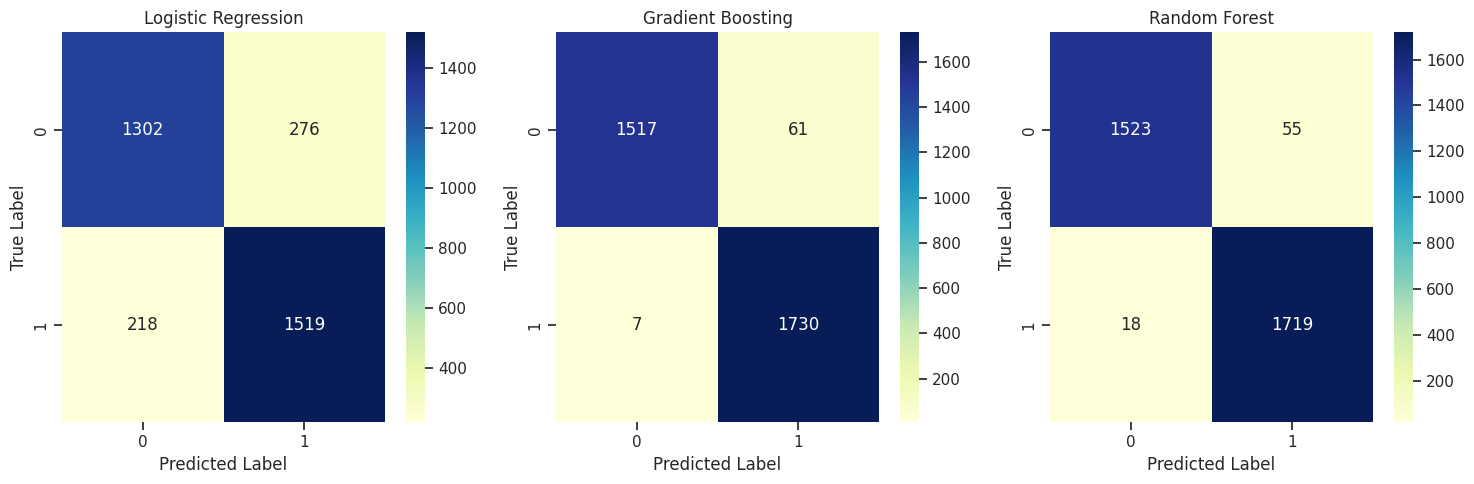

Logistic Regression  Gradient Boosting  Random Forest
Training Accuracy             0.861119           1.000000       0.999095
Testing Accuracy              0.850980           0.979487       0.977979
Precision                     0.846240           0.965941       0.968997
Recall                        0.874496           0.995970       0.989637
F1-Score                      0.860136           0.980726       0.979208

In [ ]:
# After SMOTE ENN & Standard Scaling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

models = {}
models['Logistic Regression'] = LogisticRegression(
    C=0.01, max_iter=100, penalty='l2', solver='lbfgs'
).fit(X_train_pca, y_train)
models['Gradient Boosting'] = GradientBoostingClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
    max_features= 'sqrt',
    max_depth=10
).fit(X_train_pca, y_train)
models['Random Forest'] = RandomForestClassifier(
    n_estimators=10
).fit(X_train_pca, y_train)

frame = pd.DataFrame(columns=models.keys())
conf_df = pd.DataFrame()
frame_pca, cm = model_comp(models, X_train_pca, y_train, X_test_pca, y_test, frame, conf_df)
frame_pca

## Explainable AI

### SHAP

An article about SHAP and LIME

1. https://medium.com/cmotions/opening-the-black-box-of-machine-learning-models-shap-vs-lime-for-model-explanation-d7bf545ce15f
2. https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.4 MB/s eta 0:00:00


#### Feature Importance - Global Explanations

In [ ]:
import shap
import matplotlib.pyplot as plt

model = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
).fit(norm_X_train, y_train)

print("Training Accuracy for Random Forest:",model.score(norm_X_train, y_train))

Training Accuracy for Random Forest: 0.9989434759640782


In [ ]:
# Fits the explainer
explainer = shap.Explainer(model.predict, norm_X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

ExactExplainer explainer: 3318it [05:16, 10.30it/s]                          


Here the features are ordered from the highest to the lowest effect on the prediction.

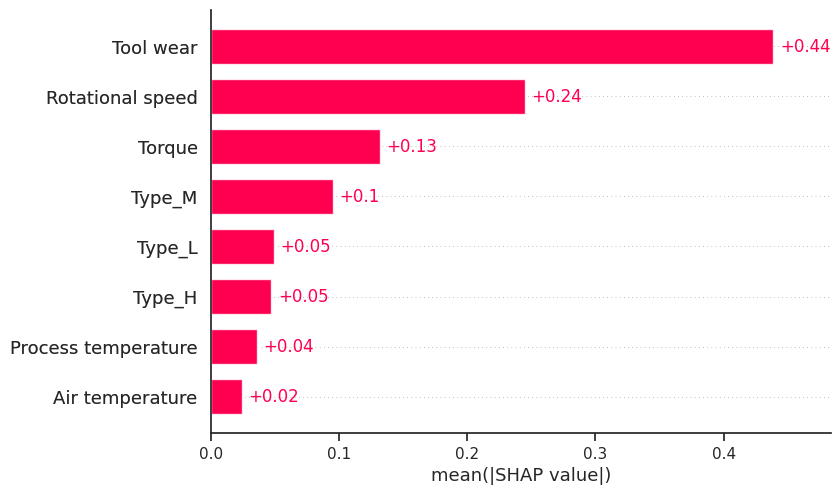

In [ ]:
shap.plots.bar(shap_values)

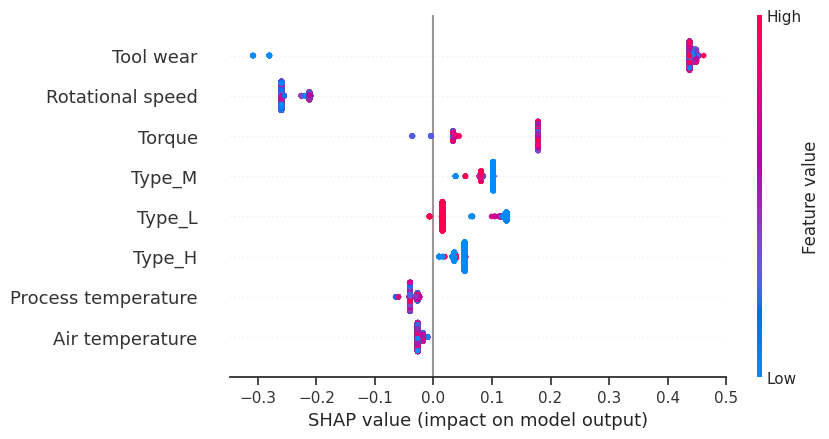

In [ ]:
shap.plots.beeswarm(shap_values)

#### Local Explanation

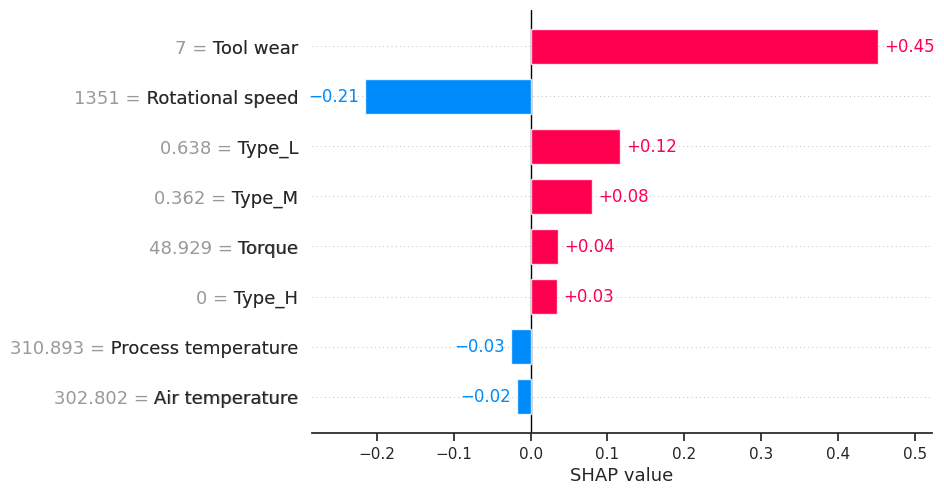

In [ ]:
shap.plots.bar(shap_values[0])

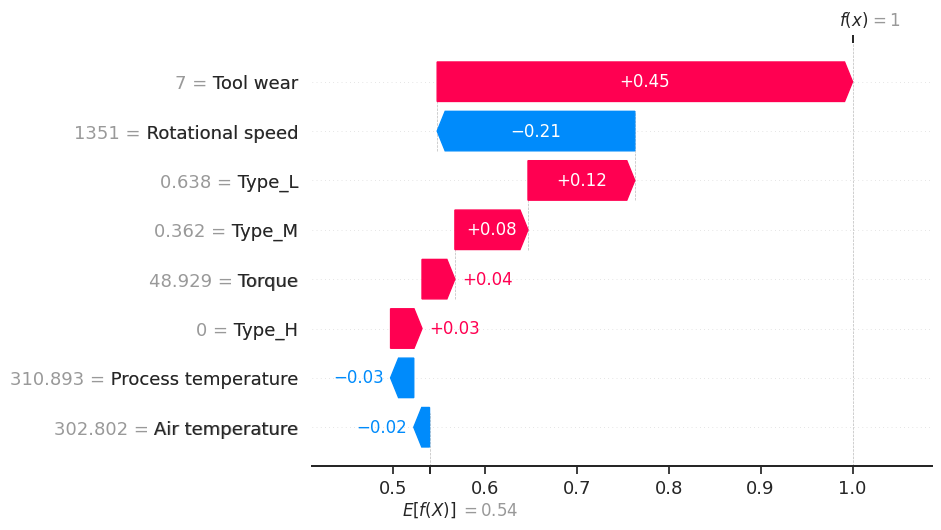

In [ ]:
shap.plots.waterfall(shap_values[0])

### LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2a903e09ceb60843e9049f3b53d45a58c03e234d17a5787347fb33a8bcc6f8a0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(norm_X_train.astype('int')),
    feature_names=norm_X_train.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [ ]:
j = 0 # Replace with the index of the instance you want to explain
instance = norm_X_train.iloc[j]

# Explain the instance
exp = explainer.explain_instance(
    data_row=norm_X_train.iloc[j],
    predict_fn=model.predict_proba
)
exp.show_in_notebook(show_table=True)